###Introduction

The International Air Transport Association predicts that 2024 will observe a significant increase in air travel for passengers (Dooley, 2023). This surge has placed pressure on airlines to forecast flight delays, a critical factor affecting airline operations. Using historical flight and weather data alongside machine learning techniques, we aim to proactively predict the binary outcome - if a flight is delayed by more than 15 minutes or not. We will make this prediction two hours prior to the scheduled departure time. We will market our model to airlines to empower them to proactively respond via operations, resources and adjustments of schedules based on the model’s predicted delays.

We use a combined dataset from the US Department of Transportation and National Oceanic and Atmospheric Administration (NOAA) which includes flight and weather data fom 2015 to 2019. We conduct our work in Databricks for a parallelized workflow when exploring data and tuning model parameters. We use the F2 score for model evaluation, which captures the optimization of precision and recall, but places more weight on the recall metric. This metric fits our aim to minimize false negative predictions, where we predict on time but the flight is ultimately delayed. In this reduced version of the full project, we will only explore random forests for predictions and use HyperOpt for optimized parameters.

Please be advised this notebook is adapted from a larger research project for University of California, Berkeley's class, [Machine Learning at Scale](https://ischoolonline.berkeley.edu/data-science/curriculum/machine-learning-at-scale/). Additionally, there is the option to either read parquet files to quickly execute this project or one can produce EDA, Feature Engineering and ML models with the code provided. User must set the variable `READ` appropriately. 

####Contents

- Feature Engineering
- Exploratory Data Analysis
- Modeling
- Random Forests
- Set Final Model Parameters
- Conclusion

In [0]:
## Place this cell in any team notebook that needs access to the team cloud storage.


# The following blob storage is accessible to team members only (read and write)
# access key is valid til TTL
# after that you will need to create a new SAS key and authenticate access again via DataBrick command line
blob_container  = "w261-project"       # The name of your container created in https://portal.azure.com
storage_account = "mids261project"  # The name of your Storage account created in https://portal.azure.com
secret_scope    = "data_extract"           # The name of the scope created in your local computer using the Databricks CLI
secret_key      = "data_team"             # The name of the secret key created in your local computer using the Databricks CLI
team_blob_url   = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"  #points to the root of your team storage bucket


# the 261 course blob storage is mounted here.
mids261_mount_path      = "/mnt/mids-w261"

# SAS Token: Grant the team limited access to Azure Storage resources
spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)


# see what's in the blob storage root folder 
display(dbutils.fs.ls(f"{team_blob_url}"))

## Project Description
The primary objective of this project is to use machine learning models to predict flight delays. Through analyzing historical flight data alongside pertinent weather information, we seek to identify patterns and factors that contribute to flight delays. The ultimate goal is to provide airlines with actionable insights that can improve operational efficiency and enhance the overall travel experience for passengers.

##### Methodology
1. **Data Collection**: We have historical flight data that has previously been joined from the Department of Transportation, National Oceanic and Atmospheric Administration (NOAA) and Airport data from a public domain source, OurAirports. The flight data encompasses a range of features including departure and arrival airports, times, airline carriers, and flight routes. The weather data includes variables such as temperature, visbility, and wind speed at specific weather stations. The airports data enabled the join between weather stations and flights data.

2. **Data Preprocessing**: We cleaned and analyzed the data prior to modeling. We casted columns to the correct datatype, handled null values, conducted feature engineering/feature normalization, did random downsampling to address class inbalance. We also performed exploratory data analysis (EDA) on the main data source to validate our understanding of the data as well as identify outliers and patterns within the data. 

3. **Modeling**: We use a random forest model to build a predictive model for flight delays. We split the data into training, validation, and test datasets. The final models were trained on 2016-2018 data, validated on February through June 2019 data, and tested on July through December 2019 data.  The models were evaluated using F2 score. 

4. **Experimentation**: We used hyperopt to find parameter values that were the best fit for our Random Forest model. We extracted those parameters and applied them back to our training and validation data, balancing finding a well fitted yet generalizable model.

5. **Results & Next Steps**: We trained our models on the final training dataset using the identified hyperparameters, and evaluated the model against the unseen validation and test sets. This provided insight into how well our model performs on unseen data, providing a glimpse into its operational reliability.



In [0]:
'''
This cell block imports all necessary libraries and sets up Spark environment 
'''

from datetime import date
from hyperopt import hp
from graphframes import GraphFrame
from hyperopt import fmin, tpe, Trials, SparkTrials, hp
from math import log10
from matplotlib import cm
from matplotlib.ticker import FuncFormatter
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, Imputer, MinMaxScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col, like, when, pandas_udf
from pyspark.sql.types import FloatType
from pyspark.sql.window import Window
from random_forest_run_folds import run_fold_evaluation

import datetime
import holidays
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import mlflow
import mlflow.spark
import numpy as np
import networkx as nx
import pandas as pd
import pyspark.sql.functions as F
import seaborn as sns
import time
import warnings

pd.set_option('display.max_columns', None)

team_blob_url = "wasbs://w261-project@mids261project.blob.core.windows.net"

display(dbutils.fs.ls(team_blob_url))

# Choose to read or run/write files
READ = True


path,name,size,modificationTime
wasbs://w261-project@mids261project.blob.core.windows.net/20152018_data_test/,20152018_data_test/,0,1713236099000
wasbs://w261-project@mids261project.blob.core.windows.net/20152018_data_train/,20152018_data_train/,0,1713236074000
wasbs://w261-project@mids261project.blob.core.windows.net/20152018_data_train_downsampled/,20152018_data_train_downsampled/,0,1713236107000
wasbs://w261-project@mids261project.blob.core.windows.net/20152018_data_val/,20152018_data_val/,0,1713236086000
wasbs://w261-project@mids261project.blob.core.windows.net/2015_ES_data_train_downsampled/,2015_ES_data_train_downsampled/,0,1713251700000
wasbs://w261-project@mids261project.blob.core.windows.net/2015_ES_data_val/,2015_ES_data_val/,0,1713251711000
wasbs://w261-project@mids261project.blob.core.windows.net/2015_ES_fold_1_train_downsampled/,2015_ES_fold_1_train_downsampled/,0,1713251758000
wasbs://w261-project@mids261project.blob.core.windows.net/2015_ES_fold_1_val/,2015_ES_fold_1_val/,0,1713251766000
wasbs://w261-project@mids261project.blob.core.windows.net/2015_ES_fold_2_train_downsampled/,2015_ES_fold_2_train_downsampled/,0,1713251805000
wasbs://w261-project@mids261project.blob.core.windows.net/2015_ES_fold_2_val/,2015_ES_fold_2_val/,0,1713251811000


## Feature Engineering

In [0]:
'''
The following cell reads in the full dataset as a dataframe and begins filtering the data to only consider delayed flights. We will also calculate the percentage of null values for each column. 
    - We have 30,893,868 rows
    - The dates range from the beginning of 2015 to the end of 2019.
'''

# read in data
df = spark.read.parquet(f"{team_blob_url}/combined_data_all/")

# check data - there should be 30,893,868 rows and dates should span 1-1-2015 and 12-31-2019
display(df.select("FL_DATE").describe())

# filter for only non-cancelled or diverted flights, cast strings to numeric
df = df.filter(
        (col("CANCELLED") == 0) &
        (col("DIVERTED") == 0)
    )

# check the percentage of null values
total_count = df.count()

null_counts = df.agg(*[
            (F.sum(col(c).isNull().cast("int")) / total_count).alias(c + "_null_percentage") 
    for c in df.columns
]).toPandas()

# display the data 
display(null_counts)



summary,FL_DATE
count,30893868
mean,null
stddev,null
min,2015-01-01
max,2019-12-31


OP_CARRIER_AIRLINE_ID_null_percentage,TAIL_NUM_null_percentage,OP_CARRIER_FL_NUM_null_percentage,ORIGIN_null_percentage,DEST_null_percentage,scheduled_departure_time_utc_null_percentage,arr_time_measured_from_2hr_null_percentage,time_measured_from_2hr_null_percentage,YEAR_null_percentage,QUARTER_null_percentage,MONTH_null_percentage,DAY_OF_MONTH_null_percentage,DAY_OF_WEEK_null_percentage,FL_DATE_null_percentage,OP_UNIQUE_CARRIER_null_percentage,OP_CARRIER_null_percentage,ORIGIN_AIRPORT_ID_null_percentage,ORIGIN_AIRPORT_SEQ_ID_null_percentage,ORIGIN_CITY_MARKET_ID_null_percentage,ORIGIN_CITY_NAME_null_percentage,ORIGIN_STATE_ABR_null_percentage,ORIGIN_STATE_FIPS_null_percentage,ORIGIN_STATE_NM_null_percentage,ORIGIN_WAC_null_percentage,DEST_AIRPORT_ID_null_percentage,DEST_AIRPORT_SEQ_ID_null_percentage,DEST_CITY_MARKET_ID_null_percentage,DEST_CITY_NAME_null_percentage,DEST_STATE_ABR_null_percentage,DEST_STATE_FIPS_null_percentage,DEST_STATE_NM_null_percentage,DEST_WAC_null_percentage,CRS_DEP_TIME_null_percentage,DEP_TIME_null_percentage,DEP_DELAY_null_percentage,DEP_DELAY_NEW_null_percentage,DEP_DEL15_null_percentage,DEP_DELAY_GROUP_null_percentage,DEP_TIME_BLK_null_percentage,TAXI_OUT_null_percentage,WHEELS_OFF_null_percentage,WHEELS_ON_null_percentage,TAXI_IN_null_percentage,CRS_ARR_TIME_null_percentage,ARR_TIME_null_percentage,ARR_DELAY_null_percentage,ARR_DELAY_NEW_null_percentage,ARR_DEL15_null_percentage,ARR_DELAY_GROUP_null_percentage,ARR_TIME_BLK_null_percentage,CANCELLED_null_percentage,CANCELLATION_CODE_null_percentage,DIVERTED_null_percentage,CRS_ELAPSED_TIME_null_percentage,ACTUAL_ELAPSED_TIME_null_percentage,AIR_TIME_null_percentage,FLIGHTS_null_percentage,DISTANCE_null_percentage,DISTANCE_GROUP_null_percentage,CARRIER_DELAY_null_percentage,WEATHER_DELAY_null_percentage,NAS_DELAY_null_percentage,SECURITY_DELAY_null_percentage,LATE_AIRCRAFT_DELAY_null_percentage,FIRST_DEP_TIME_null_percentage,TOTAL_ADD_GTIME_null_percentage,LONGEST_ADD_GTIME_null_percentage,DIV_AIRPORT_LANDINGS_null_percentage,DIV_REACHED_DEST_null_percentage,DIV_ACTUAL_ELAPSED_TIME_null_percentage,DIV_ARR_DELAY_null_percentage,DIV_DISTANCE_null_percentage,DIV1_AIRPORT_null_percentage,DIV1_AIRPORT_ID_null_percentage,DIV1_AIRPORT_SEQ_ID_null_percentage,DIV1_WHEELS_ON_null_percentage,DIV1_TOTAL_GTIME_null_percentage,DIV1_LONGEST_GTIME_null_percentage,DIV1_WHEELS_OFF_null_percentage,DIV1_TAIL_NUM_null_percentage,DIV2_AIRPORT_null_percentage,DIV2_AIRPORT_ID_null_percentage,DIV2_AIRPORT_SEQ_ID_null_percentage,DIV2_WHEELS_ON_null_percentage,DIV2_TOTAL_GTIME_null_percentage,DIV2_LONGEST_GTIME_null_percentage,DIV2_WHEELS_OFF_null_percentage,DIV2_TAIL_NUM_null_percentage,DIV3_AIRPORT_null_percentage,DIV3_AIRPORT_ID_null_percentage,DIV3_AIRPORT_SEQ_ID_null_percentage,DIV3_WHEELS_ON_null_percentage,DIV3_TOTAL_GTIME_null_percentage,DIV3_LONGEST_GTIME_null_percentage,DIV3_WHEELS_OFF_null_percentage,DIV3_TAIL_NUM_null_percentage,DIV4_AIRPORT_null_percentage,DIV4_AIRPORT_ID_null_percentage,DIV4_AIRPORT_SEQ_ID_null_percentage,DIV4_WHEELS_ON_null_percentage,DIV4_TOTAL_GTIME_null_percentage,DIV4_LONGEST_GTIME_null_percentage,DIV4_WHEELS_OFF_null_percentage,DIV4_TAIL_NUM_null_percentage,DIV5_AIRPORT_null_percentage,DIV5_AIRPORT_ID_null_percentage,DIV5_AIRPORT_SEQ_ID_null_percentage,DIV5_WHEELS_ON_null_percentage,DIV5_TOTAL_GTIME_null_percentage,DIV5_LONGEST_GTIME_null_percentage,DIV5_WHEELS_OFF_null_percentage,DIV5_TAIL_NUM_null_percentage,departure_iata_code_null_percentage,departure_airport_name_null_percentage,departure_gps_code_null_percentage,departure_airport_type_null_percentage,departure_weather_station_lat_null_percentage,departure_weather_station_lon_null_percentage,departure_weather_station_id_null_percentage,departure_iso_country_null_percentage,departure_timezone_null_percentage,arrival_iata_code_null_percentage,arrival_airport_name_null_percentage,arrival_gps_code_null_percentage,arrival_airport_type_null_percentage,arrival_weather_station_lat_null_perc

In [0]:
'''
Feature Engineering to obtain percentage delays in a given window in time (days). There is the option to read this data from a parquet file, otherwise we will create new columns to accomodate future analysis.
'''

if READ:
    df = spark.read.parquet(f"{team_blob_url}/full_feature_engineering_checkpoint1/")

else:

    # turn FL_DATE to a date type
    df = df.withColumn("FL_DATE", F.to_date(col("FL_DATE")))

    # get the holidays for the years 2015 to 2024 in the United States- this is stored as a dictionary
    us_holidays = holidays.US(years=[2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]) 

    # create empty list to store the three days before and after a holiday
    holiday_before_and_after = []

    days_before_and_after = 3

    for holiday in us_holidays.keys():
        for i in range(1, days_before_and_after+1):
            holiday_before_and_after.append(holiday + datetime.timedelta(days=i))
            holiday_before_and_after.append(holiday + datetime.timedelta(days=-i))

    # create "holidays" columns 
    df = df.withColumn("holidays",
                                F.when(df["FL_DATE"].cast("date").isin(*[F.lit(x) for x in us_holidays]), 1)
                                .otherwise(0))

    # create "around_holidays" column
    df = df.withColumn("around_holidays",
                                F.when(df["FL_DATE"].cast("date").isin(*[F.lit(x) for x in holiday_before_and_after]), 1)
                                .otherwise(0))

    def rolling_day_route_delays(window_size: int):
        """
        Calculates the percentage of flights that are delayed within a given window size

        Parameters:
            window_size: number of days for the rolling window size

        Returns: 
            dataframe with columns: OP_CARRIER_FL_NUM, OP_CARRIER_AIRLINE_ID, OP_CARRIER, ORIGIN, DEST, pct_prev_[window_size]_flights_delayed 
        """

        date_array = spark.sql("SELECT sequence(to_date('2015-01-01'), to_date('2019-12-31'), interval 1 day) as date").withColumn("FL_DATE", F.explode(col("date"))).select("FL_DATE")

        df.createOrReplaceTempView("data_view")
        date_array.createOrReplaceTempView("date_array")

        sql_query = f"""
        WITH distinct_flight_routes as (
            SELECT distinct OP_CARRIER_FL_NUM, OP_CARRIER_AIRLINE_ID, OP_CARRIER, ORIGIN, DEST
            FROM data_view
        ), cross_joined as (
            SELECT *
            FROM date_array
            CROSS JOIN distinct_flight_routes 
        ), flight_details as (
            SELECT distinct FL_DATE, OP_CARRIER_FL_NUM, OP_CARRIER_AIRLINE_ID, OP_CARRIER, ORIGIN, DEST, DEP_DEL15, 1 as flight_count
            FROM data_view
        ), daily_flights as (
            SELECT cross_joined.*, COALESCE(flight_details.DEP_DEL15, 0) as DEP_DEL15, COALESCE(flight_details.flight_count, 0) as flight_count
            FROM cross_joined
            LEFT JOIN flight_details
                USING(FL_DATE, OP_CARRIER_FL_NUM, OP_CARRIER_AIRLINE_ID, OP_CARRIER, ORIGIN, DEST)
        ) , window_calc as (
            SELECT
                distinct
                OP_CARRIER_FL_NUM,
                OP_CARRIER_AIRLINE_ID, 
                ORIGIN, 
                DEST, 
                FL_DATE,
                SUM(DEP_DEL15) OVER (
                    PARTITION BY OP_CARRIER_FL_NUM, OP_CARRIER_AIRLINE_ID, ORIGIN, DEST
                    ORDER BY FL_DATE ROWS BETWEEN {window_size} PRECEDING AND 1 PRECEDING
                    ) AS prev_{window_size}_flights_delayed,
                COUNT(*) OVER (
                    PARTITION BY OP_CARRIER_FL_NUM, OP_CARRIER_AIRLINE_ID, ORIGIN, DEST
                    ORDER BY FL_DATE ROWS BETWEEN {window_size} PRECEDING AND 1 PRECEDING
                    ) AS prev_{window_size}_flight_count
            FROM daily_flights
        ) 
        SELECT 
            OP_CARRIER_FL_NUM,
            OP_CARRIER_AIRLINE_ID, 
            ORIGIN, 
            DEST, 
            FL_DATE,
            CASE 
                WHEN prev_{window_size}_flight_count != 0 THEN prev_{window_size}_flights_delayed / prev_{window_size}_flight_count
                ELSE NULL
            END AS pct_prev_{window_size}_flights_delayed    
        FROM window_calc
        """
        return spark.sql(sql_query)

    # choose 14 days as the window size-call function with 14 days as parameter
    rolling_14_flights_delay = rolling_day_route_delays(14)

    # create new dataframe with new, calculated column
    df = df.join(rolling_14_flights_delay, ["OP_CARRIER_FL_NUM",  "OP_CARRIER_AIRLINE_ID", "ORIGIN",  "DEST", "FL_DATE"], "left")


    # write data to a parquet file
    df.write.mode("overwrite").parquet(f"{team_blob_url}/full_feature_engineering_checkpoint1_LLM")

In [0]:
'''
Feature Engineering to get % of flights delayed at departure as of 2 hours prior to departure. If it’s a flight with a scheduled departure in the first two hours of the day, it will be 0
'''
READ = True
if READ:
    df = spark.read.parquet(f"{team_blob_url}/full_feature_engineering_checkpoint2/")
else:

    '''
    create a new column called two_hours_prior_depart_local by subtracting 2 hours from the "scheduled_departure_time_local" column from df
    '''

    df = df.withColumn("two_hours_prior_depart_local", F.expr("scheduled_departure_time_local  - INTERVAL 2 HOURS"))
    df.createOrReplaceTempView("data_view")

    sql_query = """
    SELECT 
        DISTINCT
        ORIGIN,
        two_hours_prior_depart_local,
        (
            SELECT COUNT(*)
            FROM data_view
            WHERE 
                DEP_DEL15 IS NOT NULL
                AND ORIGIN = t.ORIGIN  -- Group by airport
                AND CAST(two_hours_prior_depart_local AS DATE) = CAST(t.two_hours_prior_depart_local AS DATE)  -- Filter datetime values for the same day
                AND two_hours_prior_depart_local < t.two_hours_prior_depart_local  -- Count values before the current datetime
        ) AS count_flights_before, 
        (
            SELECT SUM(DEP_DEL15)
            FROM data_view
            WHERE 
                DEP_DEL15 IS NOT NULL
                AND ORIGIN = t.ORIGIN  -- Group by airport
                AND CAST(two_hours_prior_depart_local AS DATE) = CAST(t.two_hours_prior_depart_local AS DATE)  -- Filter datetime values for the same day
                AND two_hours_prior_depart_local < t.two_hours_prior_depart_local  -- Count values before the current datetime
        ) AS count_delays_before    
    FROM 
        data_view t
    WHERE DEP_DEL15 IS NOT NULL

    """

    daily_origin_delays = spark.sql(sql_query)
    daily_origin_delays = daily_origin_delays.withColumn("origin_airport_day_pct_delay", col("count_delays_before") / col("count_flights_before")).select("ORIGIN", "two_hours_prior_depart_local", "origin_airport_day_pct_delay")


    df = df.join(daily_origin_delays, ["ORIGIN", "two_hours_prior_depart_local"], 'left')

    df.write.mode("overwrite").parquet(f"{team_blob_url}/full_feature_engineering_checkpoint2_LLM")

In [0]:
'''
Create a column calld origin_pct_prev_{window_size}_days_delay which is the % of flights delayed at departure as of 2 hours prior to departure. If it’s a flight with a scheduled departure in the first two hours of the day, it will be 0.
'''
    
if READ:
    df = spark.read.parquet(f"{team_blob_url}/full_feature_engineering_checkpoint3/")
else:

    def rolling_day_origin_delays(window_size):

        df.createOrReplaceTempView("data_view")

        sql_query = f"""
        WITH t1 as (
            SELECT
                FL_DATE,
                ORIGIN, 
                SUM(SUM(DEP_DEL15)) OVER (
                        PARTITION BY ORIGIN
                        ORDER BY FL_DATE ROWS BETWEEN {window_size} PRECEDING AND 1 PRECEDING
                        ) AS count_of_delays,
                SUM(SUM(FLIGHTS)) OVER (
                        PARTITION BY ORIGIN
                        ORDER BY FL_DATE ROWS BETWEEN {window_size} PRECEDING AND 1 PRECEDING
                        ) AS total_flights
            FROM data_view
            GROUP BY 1,2
            ORDER BY 1
        )
        SELECT 
            FL_DATE, 
            ORIGIN, 
            CASE 
                WHEN total_flights = 0 
                THEN 0 
                ELSE count_of_delays / total_flights
            END origin_pct_prev_{window_size}_days_delay
        FROM t1 
        """

        return spark.sql(sql_query)

    # call function 
    rolling_1_origin_delay = rolling_day_origin_delays(1)

    # join output of function with previous data
    df = df.join(rolling_1_origin_delay, ["FL_DATE", "ORIGIN"], "left")

    # cast create a column of YYYY-MM
    df = df.withColumn("month_date", 
                    F.to_date(F.concat(col("YEAR"), F.lit("-"), F.lpad(col("MONTH"), 2, "0"), F.lit("-01")), "yyyy-MM-dd")
    ) 

    # get the previous month of flight
    df = df.withColumn("previous_month_date", 
        F.add_months(col("month_date"), -1 )
    )

    # get the average amound of flights that are delayed in a month from each origin airport
    airport_monthly_delays = df.groupby("ORIGIN", "month_date").agg(
        F.avg(col("DEP_DEL15") * col("DEP_DELAY")).alias("dept_airport_prev_month_avg_delay")
        ).withColumnRenamed("month_date", "previous_month_date")

    # get the average amound of flights that are delayed in a month from each airline
    airline_monthly_delays = df.groupby("OP_CARRIER",  "OP_CARRIER_AIRLINE_ID", "month_date").agg(
        F.avg(col("DEP_DEL15") * col("DEP_DELAY")).alias("airline_prev_month_avg_delay")
        ).withColumnRenamed("month_date", "previous_month_date")

    # perform join on tables
    df = df.join(airport_monthly_delays, ["ORIGIN", "previous_month_date"], how = 'left')
    df = df.join(airline_monthly_delays, ["OP_CARRIER",  "OP_CARRIER_AIRLINE_ID", "previous_month_date"], how = 'left')

    df.write.mode("overwrite").parquet(f"{team_blob_url}/full_feature_engineering_checkpoint3_LLM")


In [0]:
'''
Capture seasonality with this feature by considering the previous year. For example, if the flight is on 12/31/2017, it is the % of flights delayed in the rolling 30 days of last year (12/1/16 - 12/30/16)
'''

if READ:
    df = spark.read.parquet(f"{team_blob_url}/full_feature_engineering_checkpoint4/")
else:
    
    def rolling_day_airline_delays(window_size):

        df.createOrReplaceTempView("data_view")

        sql_query = f"""
        WITH t1 as (
            SELECT
                FL_DATE,
                OP_CARRIER_AIRLINE_ID, 

                SUM(SUM(DEP_DEL15)) OVER (
                        PARTITION BY OP_CARRIER_AIRLINE_ID
                        ORDER BY FL_DATE ROWS BETWEEN {window_size} PRECEDING AND 1 PRECEDING
                        ) AS count_of_delays,
                SUM(SUM(FLIGHTS)) OVER (
                        PARTITION BY OP_CARRIER_AIRLINE_ID
                        ORDER BY FL_DATE ROWS BETWEEN {window_size} PRECEDING AND 1 PRECEDING
                        ) AS total_flights
            FROM data_view
            GROUP BY 1,2
            ORDER BY 1
        )
        SELECT 
            FL_DATE, 
            OP_CARRIER_AIRLINE_ID, 
            CASE 
                WHEN total_flights = 0 
                THEN 0 
                ELSE count_of_delays / total_flights
            END airline_pct_prev_{window_size}_days_delay
        FROM t1 
        """

        return spark.sql(sql_query)

    window_30_day = rolling_day_airline_delays(30)

    df = df.join(window_30_day, ["FL_DATE"], "left")

    df.write.mode("overwrite").parquet(f"{team_blob_url}/full_feature_engineering_checkpoint4_LLM")


In [0]:
'''
Average departure delay for each unique tail number of an aircraft within a two-hour window before the scheduled departure time.
'''

if READ:
    df = spark.read.format("parquet").load(f"{team_blob_url}/full_feature_engineering_checkpoint5")
else:

    df.createOrReplaceTempView("data_view")

    sql_query = """
        SELECT 
            DISTINCT
            TAIL_NUM,
            two_hours_prior_depart_UTC,
            COALESCE((
                SELECT AVG(DEP_DELAY)
                FROM data_view
                WHERE 
                    TAIL_NUM = t.TAIL_NUM 
                    AND CAST(two_hours_prior_depart_local AS DATE) = CAST(t.two_hours_prior_depart_local AS DATE) 
                    AND two_hours_prior_depart_UTC < t.two_hours_prior_depart_UTC
            ), 0) AS avg_day_tail_num_delay
        FROM 
            data_view t
    """

    # run the sql query
    tail_number_avg_delay = spark.sql(sql_query)

    # join the table
    df = df.join(tail_number_avg_delay, ["TAIL_NUM", "two_hours_prior_depart_UTC"])

    df.write.mode("overwrite").parquet(f"{team_blob_url}/full_feature_engineering_checkpoint5_LLM")

In [0]:
'''
Additional feature engineering to fix null values in target column and add in a sequential id for a windowed group
'''

if READ:
    df = spark.read.format("parquet").load(f"{team_blob_url}/full_feature_engineering_checkpoint")

else:
        
    # update DEP_DEL15 when values are null 
    df = df.withColumn("DEP_DEL15", 
                    when((col("DEP_DEL15").isNull()) & (col("CRS_DEP_TIME") == col("DEP_TIME")) , F.lit(0))
                    .otherwise(col("DEP_DEL15")))

    # adds a new column "flight_id", assigning a unique sequential number to each row within groups - Define a window specification
    windowSpec = Window.orderBy(["OP_CARRIER_FL_NUM","OP_CARRIER_AIRLINE_ID", "TAIL_NUM", "ORIGIN", "DEST", "scheduled_departure_time_utc"])  # Order by any column to define the order

    # Add an index column, flight_id, to the DataFrame, and assign a unique sequential number to each row within groups
    df = df.withColumn("flight_id", F.row_number().over(windowSpec))

    df.write.mode("overwrite").parquet(f"{team_blob_url}/full_feature_engineering_checkpoint_LLM")




## Exploratory Data Analysis

The flights data source includes ~31.7 million records between 2015 and 2019. We removed instances of flights that were diverted or cancelled. The goal of the project is to predict delays, so we only wanted to include flights that successfully completed their scheduled route. We are battling extreme class imbalance in the flights data, where there are about four times as many instances of on-time flights as compared to delayed flights. This will require careful consideration as we design and evaluate our models. Visualization of the imbalance can be seen below.

Given this data is time-series data, we are unable to randomly sample the data and we also want to consider data spillage so we are not using data in the model that will be unavailable in the case of predicting values real time. We will use 2015-2018 to explore our data.

In [0]:
# Don't consider the test data in 2019
df_2015_2018 = (df[df['FL_DATE']<"2019-01-01"])

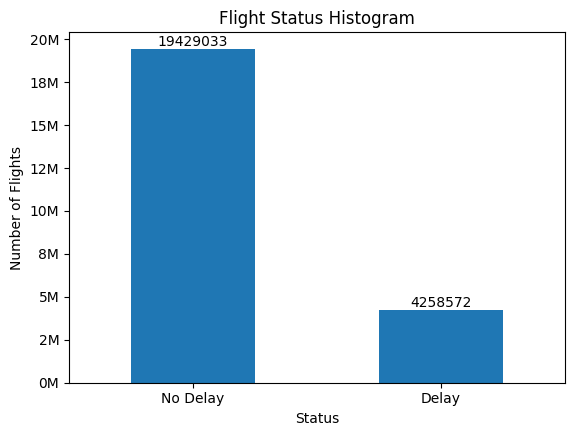

In [0]:
'''
Create histogram of the occurances of flights that are Delayed or Not Delayed 
'''

# Make sure all instances of Diverted and Cancelled ae filtered out of dataframe
df_plot_delays = df_2015_2018[df_2015_2018["DIVERTED"] != 1]
df_plot_delays = df_plot_delays[df_plot_delays["CANCELLED"] != 1]

def millions_formatter(x, pos):
    return "{:.3f}M".format(x / 1e6)


def millions_axis_formatter(x, pos):
    return "{:.0f}M".format(x / 1e6)

# get count of each class, Not Delayed and Delayed 
delay_ct = df_plot_delays.groupby(df_plot_delays.DEP_DEL15).count().toPandas()
ax = delay_ct.plot(x="DEP_DEL15", y="count", kind="bar", legend=False)
ax.yaxis.set_major_formatter(FuncFormatter(millions_axis_formatter))

# add labels to bar
for bars in ax.containers:
    ax.bar_label(bars, fmt='%.0f')

plt.subplots_adjust(bottom=0.15)
plt.ylabel("Number of Flights")
plt.xlabel("Status")
plt.xticks(range(2), ["No Delay", "Delay"], rotation=0)
plt.title("Flight Status Histogram")
plt.show()

We might also be interested in the histogram of delays, binned by the amount of delay in minutes. We can see that the majority of delays are between 15 and 29 minutes and as the binned delay times increase, the number of delay instances decreases. The bar color shows the median departure hour. We observe through this chart that flight delays typically occur in the mid afternoon across all delay durations.

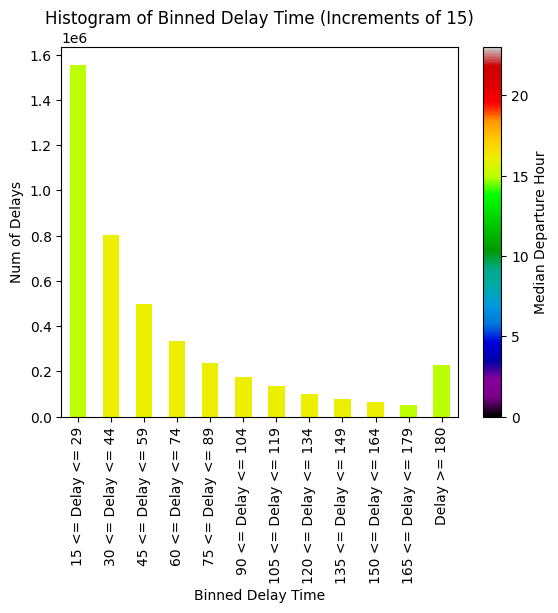

In [0]:
'''
Create histogram of the amount of flights that are delayed, binned by the delay time and colored by the median hour of the day the flights were delayed
'''


# Filter so only looking at delays more than 15 minutes
dept_status = (
    df_2015_2018[df_2015_2018["DEP_DEL15"] == 1]
    .groupby(df_2015_2018.DEP_DELAY_GROUP)
    .count()
    .toPandas()
)

# Get median hour for when there is a delay of 15 min or greater 
df_2015_2018 = df_2015_2018.withColumn('dep_hr', F.substring(df_2015_2018['DEP_TIME_BLK'], 1, 2))
median_dep_delay_hr = df_2015_2018[df_2015_2018["DEP_DEL15"] == 1].groupby(df_2015_2018.DEP_DELAY_GROUP).agg(F.median('dep_hr')).toPandas()

# Sort by the delay group
dept_status = dept_status.sort_values(by="DEP_DELAY_GROUP", ascending=False)

# Define a colormap for the hours in a day
norm = mcolors.Normalize(vmin=0, vmax=23)
cmap = plt.get_cmap("nipy_spectral")


# Create bar chart
ax = dept_status.plot(x="DEP_DELAY_GROUP",
                      y="count",
                      kind="bar", 
                      legend=False, 
                      color=cmap(norm(median_dep_delay_hr["median(dep_hr)"])))

# Set axis parameters 
ax.invert_xaxis()
ax.set_ylabel("Num of Delays")
ax.set_xlabel("Binned Delay Time")
ax.set_title("Histogram of Binned Delay Time (Increments of 15)")
ax.set_xticklabels(
    [
        "Delay >= 180",
        "165 <= Delay <= 179",
        "150 <= Delay <= 164",
        "135 <= Delay <= 149",
        "120 <= Delay <= 134",
        "105 <= Delay <= 119",
        "90 <= Delay <= 104",
        "75 <= Delay <= 89",
        "60 <= Delay <= 74",
        "45 <= Delay <= 59",
        "30 <= Delay <= 44",
        "15 <= Delay <= 29",
    ],
    rotation=90,
)

# Define the Scalable Mappable and set the colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Median Departure Hour")




The next chart investigates the visibility distance and wind speed variables. It distinguishes when there is a delay and when there is not a delay, colored by the measurements at departure and arrival airports. First and foremost, it shows that when there is a delay, the weather is typically more severe (lower visibility and higher wind speeds).

Also of interest is that when there is no delay, the disparities in average weather variables between arrival and departure airports are negligible. However, when there is a delay, we see more of a difference in weather conditions between the arrival and departure airports. This points to the fact that **weather conditions that are more out of the ordinary contribute to delays**.

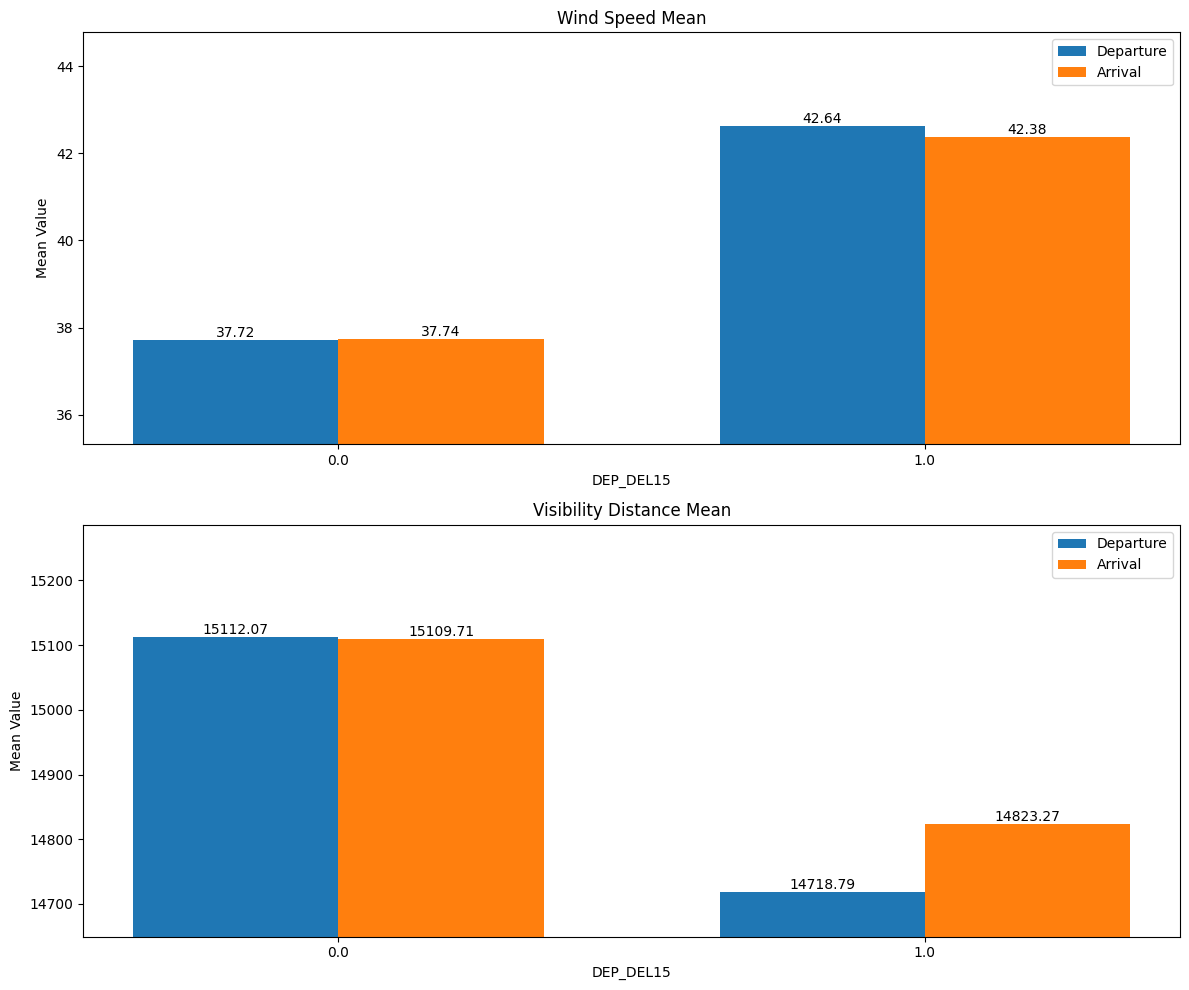

In [0]:
'''
Bar chart to convey the disparities between average 
'''

# Aggregate the data to get mean weather values for Delayed and Not Delayed flights  
mean_weather_vars = df_2015_2018.groupBy(df_2015_2018.DEP_DEL15).agg(
                                                F.mean('dep_WND_SPD').alias("dep_WND_SPD_mean"),
                                                F.mean('arr_WND_SPD').alias("arr_WND_SPD_mean"), 
                                                F.mean('dep_VIS_DIST').alias("dep_VIS_DIST_mean"),
                                                F.mean('arr_VIS_DIST').alias("arr_VIS_DIST_mean"))

# Extract data
delays = mean_weather_vars.select('DEP_DEL15').rdd.flatMap(lambda x: x).collect()
variables = ['dep_WND_SPD_mean', 'arr_WND_SPD_mean'], ['dep_VIS_DIST_mean', 'arr_VIS_DIST_mean']
medians = [mean_weather_vars.select(variable).rdd.flatMap(lambda x: x).collect() for variable in variables]

# create subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
axs = axs.ravel()
titles = ['Wind Speed Mean', 'Visibility Distance Mean']

# Plot the data 
for i, (variable1, variable2) in enumerate(variables):
    
    # Extract data and flatten
    data1 = [row[0] for row in mean_weather_vars.select(variable1).collect()]
    data2 = [row[0] for row in mean_weather_vars.select(variable2).collect()]
    
    standard_dev = np.std(data1+data2)

    bar_width = 0.35
    index = np.arange(len(data1))

    # Plot data
    bars1 = axs[i].bar(index, data1, bar_width, label="Departure")
    bars2 = axs[i].bar(index + bar_width, data2, bar_width, label="Arrival")
    axs[i].set_xlabel('DEP_DEL15')
    axs[i].set_ylabel('Mean Value')
    axs[i].set_ylim(min(min(data1, data2)) - standard_dev, max(max(data1, data2))+standard_dev)
    axs[i].set_title(titles[i])
    axs[i].set_xticks(index + bar_width / 2)
    axs[i].set_xticklabels(mean_weather_vars.select('DEP_DEL15').distinct().rdd.flatMap(lambda x: x).collect())
    axs[i].legend()

    # Add value as text on top of each bar
    for bar1, bar2, value1, value2 in zip(bars1, bars2, data1, data2):
        axs[i].text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height(), round(value1, 2), ha='center', va='bottom')
        axs[i].text(bar2.get_x() + bar2.get_width() / 2, bar2.get_height(), round(value2, 2), ha='center', va='bottom')


# layout
plt.tight_layout()
plt.show()

We calculated the percent of flights that had been delayed out of the departure airport as of two hours prior to scheduled departure. We assume if there were a large number of delays at a given airport on that day, in return, there may be  cascading delays in that airport, on that day. Similarly, we calculated the average delay length for the specific aircraft tail number as of two hours prior to departure. This feature aims to capture delays that were due to a delay from the incoming flight. We also calculated the average delay duration for both the departure airport and carrier airline over the previous month. These metrics provide valuable context for understanding historical delay patterns and their potential recurrence. Following is the naming schema of those features.


- Pct_prev_14_flights_delayed (Percent of flights of the same route in the previous 14 days that were delayed)
- Airline_pct_prev_1_days_delay (Percent of flights of that airline that were delayed the day prior to the scheduled departure)
- Origin_airport_day_pct_delay (Percent of flights at the departure airport that were delayed the day prior to the scheduled departure)
- Rolling_30_day_prev_year_pct_flight_delays (Percent of flights delayed for the rolling previous 30 days in the previous year, to capture seasonality)


Pct_prev_14_flights_delayed has a wide distribution between the first and third quantile with outliers above 50%, which indicates considerable variability in the percentage of flights delayed in the previous 14 days. Both Airline_pct_prev_1_days_delay and origin_airport_day_pct_delay do not have quite as wide of a range between the first and third quartile but again, has a lot of outlier values just above 35%. Rolling_30_day_prev_year_pct_flight_delays has a smaller distribution of values and the outliers do not extend far beyond the 3rd quartile. This indicates a more consistent pattern of flight delays over this period of time. These plots display varying degrees of varaibility and outlier presence among different variables as they pertain to flight delays.

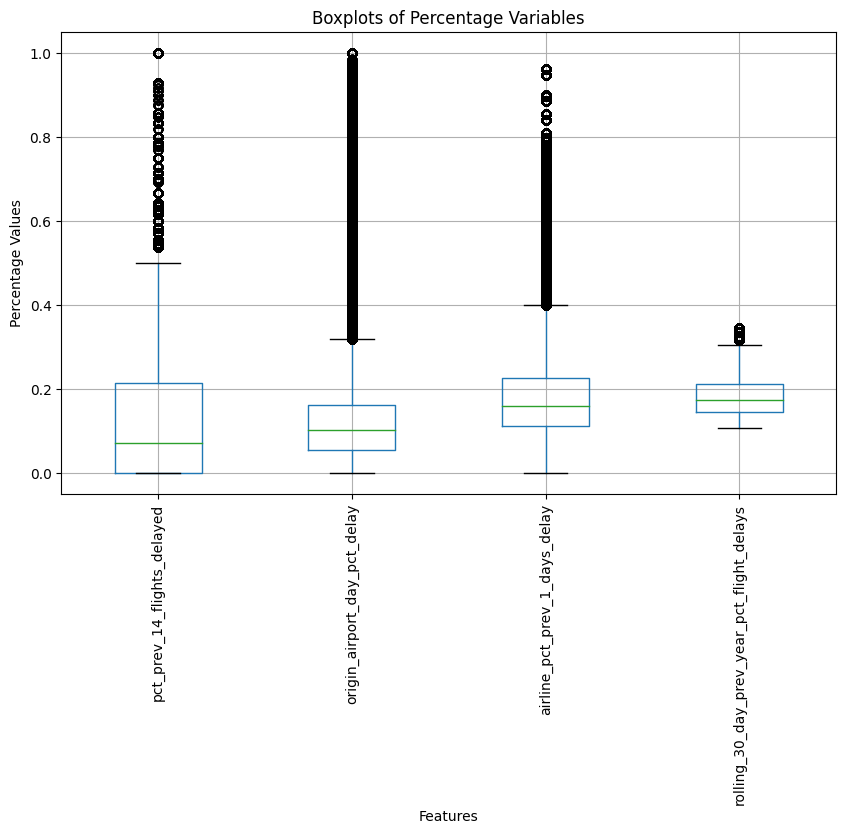

In [0]:
'''
Get boxplots of the derived delay variables 
'''

boxplot_cols = ['pct_prev_14_flights_delayed', 'origin_airport_day_pct_delay', 'airline_pct_prev_1_days_delay', 'rolling_30_day_prev_year_pct_flight_delays']

df_percentage_variables = df_2015_2018.select(*boxplot_cols).toPandas()

plt.figure(figsize=(10, 6))
df_percentage_variables.boxplot(column= boxplot_cols)
plt.title('Boxplots of Percentage Variables')
plt.xlabel('Features')
plt.ylabel('Percentage Values')
plt.xticks(rotation=90)
plt.show()

The following chart reveals that the days before and after a holiday have higher percentage of delayed flights. This is expected, as the holidays are notorious for high volume of traffic in the airport because people are traveling to spend time with their families for the holidays. The high demand for flights might make delays more susceptible because resources like pilots, flight attendants, planes, and security are already stretched during these times.

Unexpectedly, the days leading up to and following a holiday see lower mean delay times, as measured in minutes. However, it is notable that there is a major class imbalance in that there are more instances of No Holidays than Holidays +- 3 days.

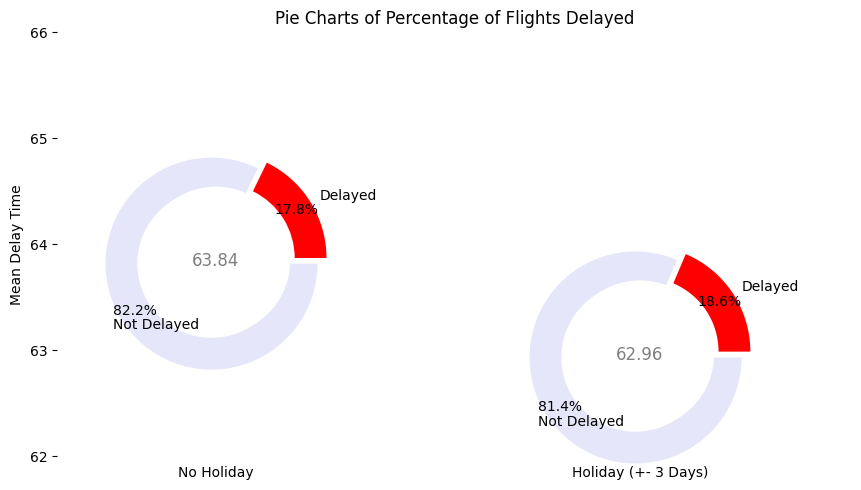

In [0]:
'''
Get percenage of flights that were delayed on days that are a holiday or +- 3 days around a holiday versus not a holiday and compare median delay times
'''

# Aggregate dataframe to get number of delays, count of flights, mean delay time and standard deviation of delay time for Holiday or Not Holiday
delays_by_holiday_around = (
    df_2015_2018.groupBy("around_holidays").agg(
        F.sum("DEP_DEL15").alias("Number of Delays"),
        F.count("DEP_DEL15").alias("Number of Flights"),
        F.mean(F.when(df_2015_2018["DEP_DEL15"] == 1, df_2015_2018["DEP_DELAY"])).alias("Mean Departure Delay (min)"),
        F.stddev(F.when(df_2015_2018["DEP_DEL15"] == 1, df_2015_2018["DEP_DELAY"])).alias("Standard Deviation Departure Delay (min)"))
    .sort(F.col("around_holidays").asc())
    .toPandas()
)

# Rename columns for interpretability 
delays_by_holiday_around = delays_by_holiday_around.rename(columns = {'around_holidays':"Holiday (0/1)"})

# Get percentage of flights delayed
delays_by_holiday_around["% Flights Delayed"] = round((
    delays_by_holiday_around["Number of Delays"] / delays_by_holiday_around["Number of Flights"]) * 100, 3)


# Create mapping between binary and displayed Holiday label
holiday_mapping = {0: "No Holiday", 1: "Holiday"}
delays_by_holiday_around['Holiday'] = delays_by_holiday_around['Holiday (0/1)'].map(holiday_mapping)
Delay_Binary = ["Delayed", "Not Delayed"]

# When there's no holiday, get percentage of delay/no delay
No_Delay_Percentage = (delays_by_holiday_around["% Flights Delayed"][0]/100)
No_Holiday_Delay = [No_Delay_Percentage, 1 - No_Delay_Percentage]

# Create the y height for each pie chart
y_positions = [delays_by_holiday_around['Mean Departure Delay (min)'][0], delays_by_holiday_around['Mean Departure Delay (min)'][1]]

# Color for pie charts
colors = ['#FF0000', '#E6E6FA']

# Explosion
explode = (0.05, 0.05)

# Define x axis mid points to make this a donut 
center_1 = 1
center_2 = 5

# Create fig and ax
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter([0] * len(y_positions), y_positions, s=0, color='gray')

# Pie Chart
ax.pie(No_Holiday_Delay, colors=colors, labels=Delay_Binary,
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode, wedgeprops=dict(width=0.3), center=(center_1, y_positions[0]))

# Draw circle
centre_circle = plt.Circle((center_1, y_positions[0]), 0.70, fc='white')
 
# Adding Circle in Pie chart
ax.add_artist(centre_circle)
 
# Adding Title of chart
ax.set_title('No Holidays')

# When there's a holiday, get percentage of delay/no delay
No_Delay_Percentage = (delays_by_holiday_around["% Flights Delayed"][1]/100)
Holiday_Delay = [No_Delay_Percentage, 1-No_Delay_Percentage]

# Pie Chart
ax.pie(Holiday_Delay, colors=colors, labels=Delay_Binary,
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode, wedgeprops=dict(width=0.3), center=(center_2, y_positions[1]))

centre_circle = plt.Circle((center_2, y_positions[1]), 0.70, fc='white')

ax.add_artist(centre_circle)
ax.set_title('Pie Charts of Percentage of Flights Delayed')

# Add text to the first pie chart
ax.text(center_1, y_positions[0], round(y_positions[0], 2), ha='center', va='center', fontsize=12, color='grey')

# Add text to the second pie chart
ax.text(center_2, y_positions[1], round(y_positions[1], 2), ha='center', va='center', fontsize=12, color='grey')

# Add x-axis ticks
ax.set_xticks([center_1, center_2])
plt.xlim([-0.5,7])
ax.set_xticklabels(['No Holiday', 'Holiday (+- 3 Days)'])
ax.tick_params(axis='x', which='both', bottom=False, top=False)


# Set y-axis parameters
plt.yticks([62, 63, 64, 65, 66, 67])#(y_positions)
plt.ylabel('Mean Delay Time')
plt.ylim([62, 66])

# Display Chart
plt.tight_layout()
plt.subplots_adjust(left=0.1)
plt.show()


When looking at the entire training dataset, instead of excusively looking at the number of delays in the dataset, we will consider the percent of flights delayed to provide a different perspective for delay comparison. This graph exhibits that Monday has the highest percentage of flights delayed while Saturday has the lowest percentage of flights delayed. We also wanted to analyze the median hour when delays occurred. Every day except Tuesday has the a median hour delay of 1pm, where Tuesday's median hour delay is 12pm. We observed similar patterns in previous charts.

Text(0.5, 1.0, 'Percentage of Delayed Flights and Median Departure Hour by Day of Week')

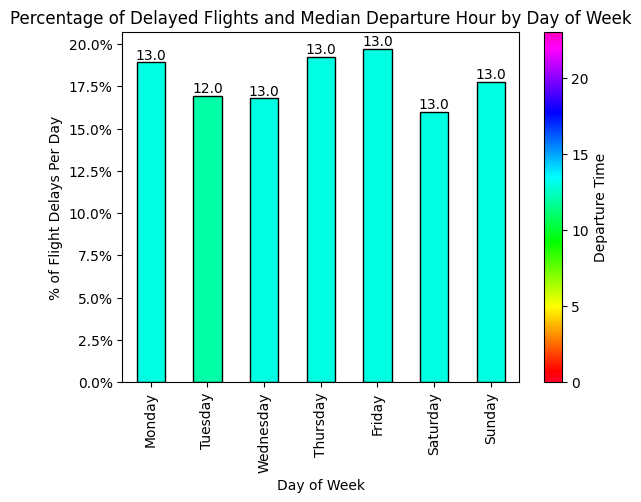

In [0]:
'''
Get number of delays and median departure time by the day of week
'''

# Get number of delays and the number of flights for each day of the week
delays_by_dow = (
    df_2015_2018.groupBy("DAY_OF_WEEK")
    .agg(
        F.sum("DEP_DEL15").alias("Number of Delays"),
        F.count("DEP_DEL15").alias("Number of Flights"))
    .sort(F.col("DAY_OF_WEEK").asc())
    .toPandas())

# Get the percentage of delayed flights by day
delays_by_dow["Delay %"] = (delays_by_dow["Number of Delays"] / delays_by_dow["Number of Flights"]) * 100

# Create mapping between day values to name of day
days_mapping = {
    1: "Monday",
    2: "Tuesday",
    3: "Wednesday",
    4: "Thursday",
    5: "Friday",
    6: "Saturday",
    7: "Sunday"}

# Conduct the mapping of values 
df = pd.DataFrame(list(days_mapping.items()), columns=["DAY_OF_WEEK", "Day of Week"])
delays_by_dow = delays_by_dow.merge(df, how="left", on=["DAY_OF_WEEK"])

# Get the hour of departure from the DEP_TIME_BLK feature
df_2015_2018_with_dep_hr = (df_2015_2018.withColumn('dep_hr', F.substring(df_2015_2018['DEP_TIME_BLK'], 1, 2)))

# Get median departure hour when there is a delay
df_2015_2018_with_dep_hr = (df_2015_2018_with_dep_hr.groupBy("DAY_OF_WEEK").agg(F.median("dep_hr"))).toPandas()

# Set scale for hours of the day
norm = mcolors.Normalize(vmin = 0, vmax=23)

cmap = plt.get_cmap("gist_rainbow")

# Plot the Delay % by the day of the week with a color map to represent median hour departure 
ax = delays_by_dow.plot(
    x="Day of Week",
    y="Delay %",
    kind="bar",
    legend=False,
    color=cmap(norm(df_2015_2018_with_dep_hr["median(dep_hr)"])),
    edgecolor="black")

# Add in the values at top of bar for improved readability 
rects = ax.patches 
labels = list(df_2015_2018_with_dep_hr["median(dep_hr)"])
for rect, label in zip(rects, labels): 
    height = rect.get_height() 
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label, 
            ha='center', va='bottom') 

# Set the Scalar Mappable and call the color map from before
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Departure Time")

# Set plot parameters 
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.subplots_adjust(bottom=0.15)
plt.xlabel("Day of Week")
plt.ylabel("% of Flight Delays Per Day")
plt.title("Percentage of Delayed Flights and Median Departure Hour by Day of Week")



In the chart below, we are further assessing the same temporal variables as percentages but grouping them by carrier. We summed the percentage values for each carrier, and while they aren't percentages that will sum to a whole, they do provide insight into the reliability or delay frequency of each carrier. United Airlines and Hawaiian Airways have the smallest summed values, while budget airlines like Jet Blue and Frontier have the highest values.

/root/.ipykernel/1364/command-2340268507078165-2133801204:80: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(rect=[0, 0.06, 1, 0.95])


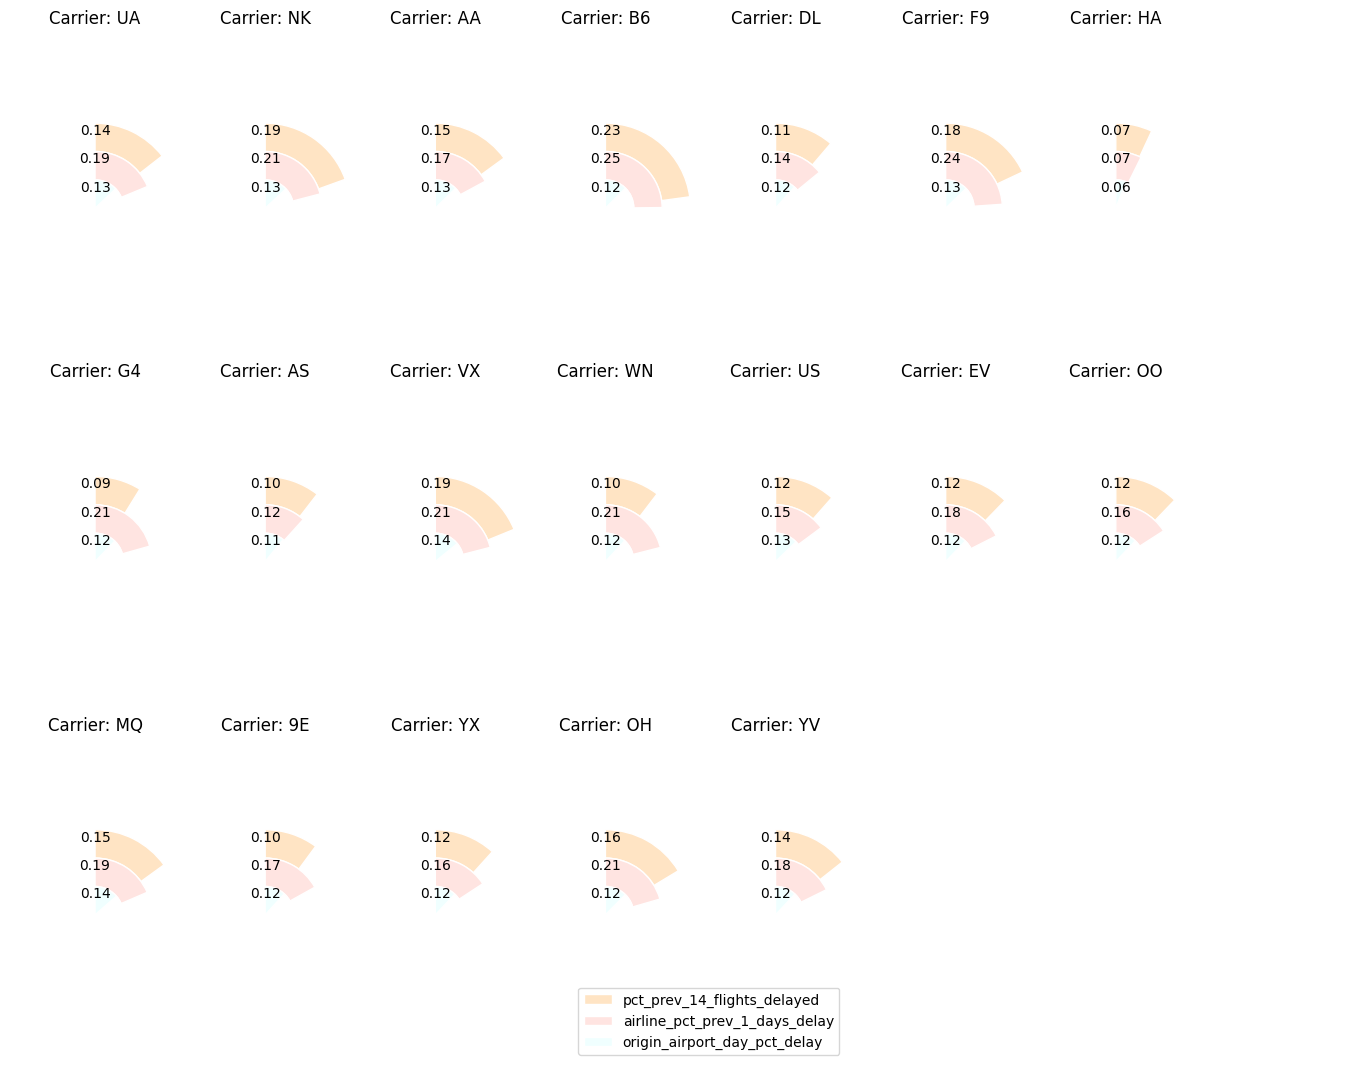

In [0]:
'''
Create gauge to represent delay percentage variables 
'''

# Aggregate data to get the mean value of each variable
percentages_by_carrier = df_2015_2018.groupBy(df_2015_2018.OP_CARRIER).agg(
                                    F.mean('pct_prev_14_flights_delayed').alias("pct_prev_14_flights_delayed"),
                                    F.mean("airline_pct_prev_1_days_delay").alias("airline_pct_prev_1_days_delay"),
                                    F.mean('origin_airport_day_pct_delay').alias("origin_airport_day_pct_delay"), 
                                    F.mean("rolling_30_day_prev_year_pct_flight_delays").alias("rolling_30_day_prev_year_pct_flight_delays"))

# Get the carriers from the data
carriers = percentages_by_carrier.select("OP_CARRIER").rdd.flatMap(lambda x: x).collect()

num_carriers = len(carriers)

# Calculate the number of rows/ columns for subplots (7 and 6 because there are 13 carriers so rows will not be even)
num_rows = (num_carriers + 6) // 7  
num_cols = min(7, num_carriers) 

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 13))

# Remove any empty subplots
if num_carriers % 7 != 0:
    for i in range(num_carriers % 7, 7):
        fig.delaxes(axes[-1, i])

labels = ['pct_prev_14_flights_delayed', 'airline_pct_prev_1_days_delay', 'origin_airport_day_pct_delay', 'rolling_30_day_prev_year_pct_flight_delays']

for idx, each_carrier in enumerate(carriers):
    data = list(percentages_by_carrier.filter(percentages_by_carrier["OP_CARRIER"] == each_carrier).collect()[0][1:-1])

    # Number of data points
    n = len(data)

    # Find max value for full ring
    k = 1 
    m = k * (1 + max(data) // k)

    # Radius of donut chart
    r = 1.5

    # Calculate width of each ring
    w = r / n 

    #create colors along a chosen colormap
    colors = ['bisque', 'mistyrose', 'azure', 'thistle']#[cm.terrain(i / n) for i in range(n)]

    num_cols = 7

    #create axis
    ax = axes[idx // num_cols, idx % num_cols]
    ax.axis("equal")

    # Loop through the values for each carrier 
    for i in range(n):
        #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
        innerring, _ = ax.pie([m - data[i], data[i]],
                                radius = r - i * w, 
                                startangle = 90, 
                                labels = ["", labels[i]], 
                                labeldistance = 1 - 1 / (1.5 * (n - i)), 
                                textprops = {"alpha": 0}, 
                                colors = ["white", colors[i]])
        plt.setp(innerring, width = w, edgecolor = "white")

        angle_rad = 0.1#(2 * np.pi * i) / n
        x = (r - i * w) * np.cos(angle_rad)
        y = (r - i * w) * np.sin(angle_rad)

        offset = 0.25 *w 
        x_text = 0 
        y_text = r - i * w - offset#y + offset * np.sin(angle_rad)

        ax.text(x_text, y_text, f'{data[i]:.2f}', ha='center', va='center')
    ax.set_title(f"Carrier: {each_carrier}", y = 1.1)

plt.legend(loc = "lower right")
plt.tight_layout(rect=[0, 0.06, 1, 0.95])
plt.show()

## Modeling

Once all the features were calculated, we applied normalization to numeric features using a MinMaxScaler, where values were based on the training data. MinMaxScaler aims to preserve the distribution of the underlying features, which was not normal in all cases. For all our experiment datasets we checkpointed the train, validation, and test datasets to parquet at multiple points throughout the feature engineering process to avoid duplication of work and runtime.

We utilized cross validation throughout training, which required careful consideration to avoid leakage between training, validation, and test datasets, where leakage is defined as leveraging data in the model that would not be available at the time of prediction. 

We created four folds per year within our 2016 - 2018 data in order to explore optimizing the hyperparameters. For each year, we used HyperOpt to calculate the optimal hyperparameters within each fold, and then used the average of those to train the model. We scaled and imputed based on the training set for that fold, and did not extract information from other folds, to avoid leakage. We created roughly balanced folds with 7 months of training data, validating using the next two months of data. All final models were trained on data spanning 2016 - 2018, validated on data data Febuary 2019 - June 2019, and tested on data from July 2019 through December 2019.



In [0]:
'''
Set up the ranges of dates for the train, validate and test data. 
Training data will be between 2016 and 2018 and specific folds for train will be defined after
Validation data will be between February 2019 to end of June 2019. Specific validation folds will be defined after
Testing data will be between July 2019 to end of December 2019. 

After defining the ranges, will create folds for training and validating models 
'''

# set up variables for modeling
model_year = 2016_2018

# Set start and end dates
full_train_start_date = f"2016-01-01"
full_train_end_date = f"2018-12-31"
full_train_file_name = f"{model_year}_data_train"

full_val_start_date = f"2019-02-01"
full_val_end_date = f"2019-06-30"
full_val_file_name = f"{model_year}_data_val"

test_start_date = f"2019-07-01"
test_end_date = f"2019-12-31"
test_file_name = f"{model_year}_data_test"

# Folds
num_folds = 4

fold_n_train_start_date = [f"2016-01-01", f"2016-10-01", f"2017-07-01", f"2018-04-01"] # every nine months
fold_n_train_end_date = [f"2016-07-31", f"2017-04-30", f"2018-01-31", f"2018-10-31"] # training duration is 8 months
fold_n_train_file_name = [f"{model_year}_fold_1_train", f"{model_year}_fold_2_train", f"{model_year}_fold_3_train", f"{model_year}_fold_4_train"]

fold_n_val_start_date = [f"2016-08-01", f"2017-05-01", f"2018-02-01", f"2018-11-01"] # fold is every nine months
fold_n_val_end_date = [f"2016-09-30", f"2017-06-30", f"2018-03-31", f"2018-12-31"] # validation duration is 2 months
fold_n_val_file_name = [f"{model_year}_fold_1_val", f"{model_year}_fold_2_val", f"{model_year}_fold_3_val", f"{model_year}_fold_4_val"]

In [0]:
'''
Prepare data to be ingested by model. Chose the features from previous regularization work that was not included.
'''

# read in full dataset 
df = spark.read.format("parquet").load(f"{team_blob_url}/full_feature_engineering_checkpoint")

# Keep only relevant
df = df.select(['FL_DATE', 'CRS_DEP_TIME', 'DISTANCE', 'around_holidays', 'arr_VIS_DIST', 'arr_WND_SPD', 'dep_VIS_DIST', 'dep_WND_SPD', 'pct_prev_14_flights_delayed', 'avg_day_tail_num_delay', 'origin_airport_day_pct_delay', 'dept_airport_prev_month_avg_delay', 'airline_pct_prev_1_days_delay', 'rolling_30_day_prev_year_pct_flight_delays', 'DEP_DEL15', 'DEP_TIME', 'DEP_DELAY', 'ARR_TIME', 'CRS_ARR_TIME', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'flight_id'])

# Convert numeric columns to integers
df = df.withColumn("DEP_DEL15", col("DEP_DEL15").cast("integer"))
df = df.withColumn("CRS_DEP_TIME", col("CRS_DEP_TIME").cast("integer"))
df = df.withColumn("DISTANCE", col("DISTANCE").cast("integer"))
df = df.withColumn("arr_VIS_DIST", col("arr_VIS_DIST").cast("integer"))
df = df.withColumn("dep_VIS_DIST", col("dep_VIS_DIST").cast("integer"))
df = df.withColumn("arr_WND_SPD", col("arr_WND_SPD").cast("integer"))
df = df.withColumn("dep_WND_SPD", col("dep_WND_SPD").cast("integer"))
df = df.withColumn("pct_prev_14_flights_delayed", col("pct_prev_14_flights_delayed").cast("double"))
df = df.withColumn("avg_day_tail_num_delay", col("avg_day_tail_num_delay").cast("double"))
df = df.withColumn("origin_airport_day_pct_delay", col("origin_airport_day_pct_delay").cast("double"))
df = df.withColumn("dept_airport_prev_month_avg_delay", col("dept_airport_prev_month_avg_delay").cast("double"))
df = df.withColumn("airline_pct_prev_1_days_delay", col("airline_pct_prev_1_days_delay").cast("double"))
df = df.withColumn("rolling_30_day_prev_year_pct_flight_delays", col("rolling_30_day_prev_year_pct_flight_delays").cast("double"))

# Add columns for post prediction analysis
df = df.withColumn("DEP_TIME", col("DEP_TIME").cast("integer"))
df = df.withColumn("DEP_DELAY", col("DEP_DELAY").cast("double"))
df = df.withColumn("ARR_TIME", col("ARR_TIME").cast("integer"))
df = df.withColumn("CRS_ARR_TIME", col("CRS_ARR_TIME").cast("integer"))
df = df.withColumn("CARRIER_DELAY", col("CARRIER_DELAY").cast("double"))
df = df.withColumn("WEATHER_DELAY", col("WEATHER_DELAY").cast("double"))
df = df.withColumn("NAS_DELAY", col("NAS_DELAY").cast("double"))
df = df.withColumn("SECURITY_DELAY", col("SECURITY_DELAY").cast("double"))
df = df.withColumn("LATE_AIRCRAFT_DELAY", col("LATE_AIRCRAFT_DELAY").cast("double"))


In [0]:
'''
User defined function
'''

def scale_numerical(df, numerical_scaler_model = None, imputer_model = None):
    """
    Scale the numerical features in the DataFrame.

    Parameters:
        df -> DataFrame: Input DataFrame containing the numerical features to be scaled.
        numerical_scaler_model: Model for scaling the numerical features. (Default: None)

    Returns:
        DataFrame: DataFrame with the numerical features scaled and combined with the other features.
        MinMaxScaler: Trained scaler model
    """

    features_to_scale = ['CRS_DEP_TIME', 'DISTANCE', 'arr_VIS_DIST', 'arr_WND_SPD', 'dep_VIS_DIST', 'dep_WND_SPD', 'pct_prev_14_flights_delayed', 'avg_day_tail_num_delay', 'origin_airport_day_pct_delay', 'dept_airport_prev_month_avg_delay', 'airline_pct_prev_1_days_delay', 'rolling_30_day_prev_year_pct_flight_delays']

    if imputer_model == None:
        imputer = Imputer(inputCols= features_to_scale, outputCols=features_to_scale).setStrategy("median")
        imputer_model = imputer.fit(df)
        
    df = imputer_model.transform(df)

    assembler = VectorAssembler(inputCols=features_to_scale, outputCol='features_scaled_assembled')
    df = assembler.transform(df)

    if numerical_scaler_model == None:
        numerical_scaler = MinMaxScaler(inputCol='features_scaled_assembled', outputCol='scaled_features')
        numerical_scaler_model = numerical_scaler.fit(df)
    df = numerical_scaler_model.transform(df)

    all_features = ["scaled_features", "around_holidays"]

    assembler = VectorAssembler(inputCols=all_features, outputCol="final_features", handleInvalid="skip")
    return assembler.transform(df), numerical_scaler_model, imputer_model

In [0]:
'''
Create and scale training data
'''

if READ:
  train_DF_VA = spark.read.format("parquet").load(f"{team_blob_url}/{full_train_file_name}")

else:
  # Filter by training data dates.
  train_df = df.filter((df['FL_DATE'] >= full_train_start_date) & (df['FL_DATE'] <= full_train_end_date))

  # Scale values in training data.
  train_df, numerical_scaler_model, imputer_model = scale_numerical(train_df)

  # Select variables of interest.
  train_DF_VA = train_df.select(['final_features', 'DEP_DEL15', 'flight_id'])

  # Rename label
  train_DF_VA = train_DF_VA.select(
      F.col('final_features').alias('features'),
        F.col('DEP_DEL15').alias('label'), 
        col("flight_id")
    )
  
  # Drop redundant features.
  train_DF_VA = train_DF_VA.drop("DEP_DEL15")
  train_DF_VA = train_DF_VA.drop("final_features")

  train_DF_VA.write.mode("overwrite").parquet(f"{team_blob_url}/{full_train_file_name}_LLM")

# Display data frame
train_DF_VA.limit(10).toPandas()

,features,label,flight_id
0,"[0.8727735368956743, 0.07588294651866802, 0.10...",1,12981581
1,"[0.6357082273112807, 0.31523713420787086, 0.10...",1,12981583
2,"[0.6361323155216285, 0.31523713420787086, 0.10...",0,12981584
3,"[0.6361323155216285, 0.31523713420787086, 0.10...",0,12981585
4,"[0.9067005937234944, 0.07588294651866802, 0.10...",0,12981587
5,"[0.9067005937234944, 0.07588294651866802, 0.10...",0,12981588
6,"[0.910941475826972, 0.07588294651866802, 0.100...",0,12981589
7,"[0.910941475826972, 0.07588294651866802, 0.100...",0,12981590
8,"[0.909245122985581, 0.07588294651866802, 0.100...",1,12981591
9,"[0.9071246819338422, 0.07588294651866802, 0.10...",0,12981592


In [0]:
'''
Create and scale validation data
'''

if READ:
   val_DF_VA = spark.read.format("parquet").load(f"{team_blob_url}/{full_val_file_name}")
else:
   # Filter by validation data dates.
   val_df = df.filter((df['FL_DATE'] >= full_val_start_date) & (df['FL_DATE'] <= full_val_end_date))

   # Scale the values.
   val_df = scale_numerical(val_df, numerical_scaler_model, imputer_model)[0]

   # Select only variables of interest
   val_DF_VA = val_df.select(['final_features', 'DEP_DEL15',  'flight_id'])

   # Rename label
   val_DF_VA = val_DF_VA.select(
      F.col('final_features').alias('features'),
         F.col('DEP_DEL15').alias('label'), 
         col("flight_id")
      )
   
   # Drop redundant features
   val_DF_VA = val_DF_VA.drop("DEP_DEL15")
   val_DF_VA = val_DF_VA.drop("final_features")

   val_DF_VA.write.mode("overwrite").parquet(f"{team_blob_url}/{full_val_file_name}_LLM")


In [0]:
'''
Create and scale test data


if READ:
   test_DF_VA = spark.read.format("parquet").load(f"{team_blob_url}/{test_file_name}")\

else:
   # Filter by testing data dates. 
   test_df = df.filter((df['FL_DATE'] >= test_start_date) & (df['FL_DATE'] <= test_end_date))

   # Scale test data
   test_df = scale_numerical(test_df, numerical_scaler_model, imputer_model)[0]

   # select only features of interest
   test_DF_VA = test_df.select(['final_features', 'DEP_DEL15', 'flight_id'])

   # Rename label
   test_DF_VA = test_DF_VA.select(
      F.col('final_features').alias('features'),
         F.col('DEP_DEL15').alias('label'),
         col("flight_id")
      )
   
   # Drop redundant features
   test_DF_VA = test_DF_VA.drop("DEP_DEL15")
   test_DF_VA = test_DF_VA.drop("final_features")

   # Checkpoint file
   test_DF_VA.write.mode("overwrite").parquet(f"{team_blob_url}/{test_file_name}_LLM")'''

'\nCreate and scale test data\n\n\nif READ:\n   test_DF_VA = spark.read.format("parquet").load(f"{team_blob_url}/{test_file_name}")\nelse:\n   # Filter by testing data dates. \n   test_df = df.filter((df[\'FL_DATE\'] >= test_start_date) & (df[\'FL_DATE\'] <= test_end_date))\n\n   # Scale test data\n   test_df = scale_numerical(test_df, numerical_scaler_model, imputer_model)[0]\n\n   # select only features of interest\n   test_DF_VA = test_df.select([\'final_features\', \'DEP_DEL15\', \'flight_id\'])\n\n   # Rename label\n   test_DF_VA = test_DF_VA.select(\n      F.col(\'final_features\').alias(\'features\'),\n         F.col(\'DEP_DEL15\').alias(\'label\'),\n         col("flight_id")\n      )\n   \n   # Drop redundant features\n   test_DF_VA = test_DF_VA.drop("DEP_DEL15")\n   test_DF_VA = test_DF_VA.drop("final_features")\n\n   # Checkpoint file\n   test_DF_VA.write.mode("overwrite").parquet(f"{team_blob_url}/{test_file_name}_LLM")'

In [0]:
'''
Downsample the data for balanced classes.
'''

def downsample(train_df, verbose=False):
  '''
  Downsamples train_df to balance classes
  
  Parameters:
      train_df: training data 

  Returns: downsampled training data

  '''

  #balance classes in train
  delay_count = train_df.filter(F.col("label") == 1).count()
  non_delay_count = train_df.filter(F.col("label") == 0).count()

  total = delay_count + non_delay_count
  keep_percent = delay_count / non_delay_count
  
  train_delay = train_df.filter(F.col('label') == 1)
  train_non_delay = train_df.filter(F.col('label') == 0).sample(withReplacement=False,fraction=keep_percent,seed=42)
  train_downsampled = train_delay.union(train_non_delay)
  return train_downsampled

if READ:
  train_DF_VA_downsampled = spark.read.format("parquet").load(f"{team_blob_url}/{full_train_file_name}_downsampled")
  
else:
  # train 
  train_DF_VA_downsampled = downsample(train_DF_VA)
  train_DF_VA_downsampled.write.mode("overwrite").parquet(f"{team_blob_url}/{full_train_file_name}_downsampled_LLM")



In [0]:
'''
Create folds for train and validation data 
'''

if READ: 
    pass
else:
    for n in range(num_folds):
        print(f"Creating fold {n+1}")
        
        ##### CREATE TRAIN FOLD ######
        fold_n_train = df.filter((df['FL_DATE'] >= fold_n_train_start_date[n]) & (df['FL_DATE'] <= fold_n_train_end_date[n]))

        # scale the data 
        train_df, numerical_scaler_model, imputer_model = scale_numerical(fold_n_train)

        # Keep only two columns
        train_DF_VA = train_df.select(['final_features', 'DEP_DEL15', "flight_id"])

        # Rename label
        train_DF_VA = train_DF_VA.select(
            F.col('final_features').alias('features'),
            F.col('DEP_DEL15').alias('label'), 
            col("flight_id")
        )
        train_DF_VA = train_DF_VA.drop("DEP_DEL15")
        train_DF_VA = train_DF_VA.drop("final_features")

        # Write file
        fold_n_train_downsampled = downsample(train_DF_VA)
        print(f"Writing file {fold_n_train_file_name[n]}_downsampled")
        fold_n_train_downsampled.write.mode("overwrite").parquet(f"{team_blob_url}/{fold_n_train_file_name[n]}_downsampled_LLM")

        ##### CREATE VAL FOLD #####
        fold_n_val = df.filter((df['FL_DATE'] >= fold_n_val_start_date[n]) & (df['FL_DATE'] <= fold_n_val_end_date[n]))
        
        val_df = scale_numerical(fold_n_val, numerical_scaler_model, imputer_model)[0]

        # Keep only two columns
        val_DF_VA = val_df.select(['final_features', 'DEP_DEL15'])

        # Rename label
        val_DF_VA = val_DF_VA.select(
            F.col('final_features').alias('features'),
            F.col('DEP_DEL15').alias('label'), 
            col("flight_id")
        )
        val_DF_VA = val_DF_VA.drop("DEP_DEL15")
        val_DF_VA = val_DF_VA.drop("final_features")

        # Write file
        print(f"Writing file {fold_n_val_file_name[n]}")
        val_DF_VA.write.mode("overwrite").parquet(f"{team_blob_url}/{fold_n_val_file_name[n]}_LLM")

## Random Forests

We split into four folds to get best hyper parameters. We display the following values for each fold
- hyperopt_time -> Time to produce hyperparameter optimization (in seconds)
- best_max_depth -> Best value for the max_depth hyperparameter. It is the maximum depth of the trees in the model
- best_num_trees -> The optimal number of trees in the ensemble
- best_weight_per_node -> Weight for each node
- best_subsampling_rate -> The fraction of the training data to be used for training each tree

These values represent the best hyperparameters found during the optimization process that are expected to give the best performance for the model.

In [0]:
'''
Initiate the naming schema of the training data file names 
Set up the parameters for a Random Forest classification solution. 
'''

model_year = 2016_2018

full_train_downsampled = f"{model_year}_data_train_downsampled"
full_val = f"{model_year}_data_val"

fold1train = f"{model_year}_fold_1_train_downsampled"
fold1val = f"{model_year}_fold_1_val"

fold2train = f"{model_year}_fold_2_train_downsampled"
fold2val = f"{model_year}_fold_2_val"

fold3train = f"{model_year}_fold_3_train_downsampled"
fold3val = f"{model_year}_fold_3_val"

fold4train = f"{model_year}_fold_4_train_downsampled"
fold4val = f"{model_year}_fold_4_val"

model_files_name = f"random_forest_{model_year}"
experiment_name = f"Random Forest {model_year}"


# Define parameter search space
search_space = {
    "max_depth": hp.quniform("max_depth", 2, 5, 1),
    "num_trees": hp.quniform("num_trees", 10, 50, 1),
    "weight_per_node": hp.loguniform("weight_per_node", -5, -1),
    "subsampling_rate": hp.uniform("subsampling_rate", 0, 1)
}

num_evals = 10

rf = RandomForestClassifier(labelCol="label", featuresCol="features", maxBins=40, seed=42)
pipeline = Pipeline(stages=[rf])

# Model evaluation - BXE
evaluator = MulticlassClassificationEvaluator(metricName='weightedFMeasure', beta=2) # was metricName = f1

warnings.filterwarnings('ignore')

mlflow.pyspark.ml.autolog(log_models=False)

#### Fold 1

In [0]:
'''
Run cross fold evaluation to get best hyperparameters for Fold 1.
'''

# read in fold data 
fold_1_train = spark.read.format("parquet").load(f"{team_blob_url}/{fold1train}")
fold_1_val = spark.read.format("parquet").load(f"{team_blob_url}/{fold1val}")

# set timer
start_time = time.time()

# set trials
trials = Trials()

# run evauation 
best_hyperparam = run_fold_evaluation(fold_1_train, fold_1_val, search_space, num_evals, trials, pipeline, rf, evaluator)

hyperopt_time_1 = round((time.time() - start_time), 1)
print("Hyperopt time fold 1:", hyperopt_time_1)

max_depth_1 = best_hyperparam["max_depth"]
num_trees_1 = best_hyperparam["num_trees"]
weight_per_node_1 = best_hyperparam["weight_per_node"]
subsampling_rate_1 = best_hyperparam["subsampling_rate"]



  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

2024/07/21 17:06:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '37cd44081c68472e801ec794891a3b18', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:06:26 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:06:55 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 10%|█         | 1/10 [00:37<05:38, 37.66s/trial, best loss: -0.7474180311605741]

2024/07/21 17:07:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '65603cda09e14a8993208e10ccd6ce6d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:07:03 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:07:18 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 20%|██        | 2/10 [01:01<03:55, 29.39s/trial, best loss: -0.7514090825077733]

2024/07/21 17:07:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b7f8d436c8fb4f7797d9ddfb01c55929', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:07:26 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:07:41 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 30%|███       | 3/10 [01:23<03:03, 26.16s/trial, best loss: -0.7520657981694215]

2024/07/21 17:07:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2742e1fb69e84cbe9d249bfd7bffa330', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:07:48 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:08:06 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 40%|████      | 4/10 [01:49<02:35, 25.95s/trial, best loss: -0.7520657981694215]

2024/07/21 17:08:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '47c16c8636bb44cea650a565f1c90684', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:08:14 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:08:26 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 50%|█████     | 5/10 [02:08<01:58, 23.61s/trial, best loss: -0.7520657981694215]

2024/07/21 17:08:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1589d24f644a4b03b35cb0c1f4e2f70d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:08:34 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:08:46 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 60%|██████    | 6/10 [02:28<01:29, 22.44s/trial, best loss: -0.7520657981694215]

2024/07/21 17:08:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8a902c2c7c2949b1afffed00174c20f6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:08:54 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:09:08 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 70%|███████   | 7/10 [02:50<01:06, 22.29s/trial, best loss: -0.779482488941481] 

2024/07/21 17:09:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b6c46ae101ec41f7a0220b05fdf5dd98', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:09:16 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:09:35 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 80%|████████  | 8/10 [03:17<00:47, 23.73s/trial, best loss: -0.779482488941481]

2024/07/21 17:09:41 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3873fa4c202d4e488b5c900fd144e953', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:09:43 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:09:56 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 90%|█████████ | 9/10 [03:38<00:22, 22.94s/trial, best loss: -0.779482488941481]

2024/07/21 17:10:02 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '686da27ec5074647b343d8c3051fd9ae', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:10:03 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:10:20 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



100%|██████████| 10/10 [04:03<00:00, 24.33s/trial, best loss: -0.779482488941481]
Hyperopt time fold 1: 243.3


In [0]:
print("hyperopt_time:", hyperopt_time_1)
print("best_max_depth:", best_hyperparam["max_depth"])
print("best_num_trees:", best_hyperparam["num_trees"])
print("best_weight_per_node:", best_hyperparam["weight_per_node"])
print("best_subsampling_rate:", best_hyperparam["subsampling_rate"])

hyperopt_time: 243.3
best_max_depth: 5.0
best_num_trees: 13.0
best_weight_per_node: 0.11039553155164417
best_subsampling_rate: 0.9969872099001056


#### Fold 2

In [0]:
'''
Run cross fold evaluation to get best hyperparameters for Fold 2.
'''

# Fold 2
fold_2_train = spark.read.format("parquet").load(f"{team_blob_url}/{fold2train}")
fold_2_val = spark.read.format("parquet").load(f"{team_blob_url}/{fold2val}")


start_time = time.time()

num_evals = 10
trials = Trials()

best_hyperparam = run_fold_evaluation(fold_2_train, fold_2_val, search_space, num_evals, trials, pipeline, rf, evaluator)

hyperopt_time_2 = round((time.time() - start_time), 1)
print("Hyperopt time fold 2:", hyperopt_time_2)


max_depth_2 = best_hyperparam["max_depth"]
num_trees_2 = best_hyperparam["num_trees"]
weight_per_node_2 = best_hyperparam["weight_per_node"]
subsampling_rate_2 = best_hyperparam["subsampling_rate"]



  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

2024/07/21 17:10:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '77a203deda1745c5b8cc4e63365bd4b7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:10:30 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:10:48 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 10%|█         | 1/10 [00:26<03:57, 26.44s/trial, best loss: -0.687006654082304]

2024/07/21 17:10:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '92bb7c360c044ec1b0b5498a7e64345e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:10:56 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:11:12 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 20%|██        | 2/10 [00:50<03:18, 24.87s/trial, best loss: -0.687006654082304]

2024/07/21 17:11:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0228f8afea884b16abf91dbb6aa67dd1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:11:20 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:11:34 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 30%|███       | 3/10 [01:12<02:45, 23.69s/trial, best loss: -0.6961924643016378]

2024/07/21 17:11:41 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '42ac414dae2e4166be9ba700873b61c5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:11:42 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:11:59 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 40%|████      | 4/10 [01:37<02:24, 24.13s/trial, best loss: -0.6961924643016378]

2024/07/21 17:12:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '748055074b014b2f9ad5e593edbad0c2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:12:07 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:12:18 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 50%|█████     | 5/10 [01:55<01:50, 22.13s/trial, best loss: -0.7505262042015451]

2024/07/21 17:12:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f5d531f4109440c49b39ea7aab5afa4d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:12:25 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:12:37 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 60%|██████    | 6/10 [02:14<01:24, 21.02s/trial, best loss: -0.7505262042015451]

2024/07/21 17:12:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c91f3ae7e1dc44b893f8f54bd5e160db', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:12:45 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:12:58 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 70%|███████   | 7/10 [02:36<01:03, 21.26s/trial, best loss: -0.7590035614949088]

2024/07/21 17:13:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4e5e9f5fb1d24facb826ba2975644b54', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:13:06 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:13:25 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 80%|████████  | 8/10 [03:02<00:45, 22.89s/trial, best loss: -0.7590035614949088]

2024/07/21 17:13:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '678111d68d994048aa85cadf5c2ec18b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:13:33 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:13:45 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 90%|█████████ | 9/10 [03:22<00:21, 21.95s/trial, best loss: -0.7590035614949088]

2024/07/21 17:13:51 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '17780b860504439e9eb8a8c3a8587371', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:13:53 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:14:10 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



100%|██████████| 10/10 [03:48<00:00, 22.82s/trial, best loss: -0.7590035614949088]
Hyperopt time fold 2: 228.2


In [0]:
print("hyperopt_time:", hyperopt_time_2)
print("best_max_depth:", best_hyperparam["max_depth"])
print("best_num_trees:", best_hyperparam["num_trees"])
print("best_weight_per_node:", best_hyperparam["weight_per_node"])
print("best_subsampling_rate:", best_hyperparam["subsampling_rate"])

hyperopt_time: 228.2
best_max_depth: 5.0
best_num_trees: 13.0
best_weight_per_node: 0.11039553155164417
best_subsampling_rate: 0.9969872099001056


#### Fold 3

In [0]:
'''
Run cross fold evaluation to get best hyperparameters for Fold 3.
'''

# Fold 3
fold_3_train = spark.read.format("parquet").load(f"{team_blob_url}/{fold3train}")
fold_3_val = spark.read.format("parquet").load(f"{team_blob_url}/{fold3val}")

start_time = time.time()

trials = Trials()

# Set up method of evaluation
best_hyperparam = run_fold_evaluation(fold_3_train, fold_3_val, search_space, num_evals, trials, pipeline, rf, evaluator)

hyperopt_time_3 = round((time.time() - start_time), 1)
print("Hyperopt time fold 3:", hyperopt_time_3)

max_depth_3 = best_hyperparam["max_depth"]
num_trees_3 = best_hyperparam["num_trees"]
weight_per_node_3 = best_hyperparam["weight_per_node"]
subsampling_rate_3 = best_hyperparam["subsampling_rate"]




  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

2024/07/21 17:14:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'aed02a9004ee4a7bb674e0467c151316', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:14:19 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:14:35 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 10%|█         | 1/10 [00:24<03:41, 24.63s/trial, best loss: -0.7404962250104676]

2024/07/21 17:14:42 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ac13c7ea5eba40c7a07049631f875964', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:14:44 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:14:58 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 20%|██        | 2/10 [00:47<03:08, 23.52s/trial, best loss: -0.7404962250104676]

2024/07/21 17:15:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '42bcc2c8eb7e4736a0d5a32748d6e2ff', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:15:06 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:15:20 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 30%|███       | 3/10 [01:08<02:38, 22.63s/trial, best loss: -0.7404962250104676]

2024/07/21 17:15:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ccb8693770de4e988d16d7f424e2d5d6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:15:28 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:15:45 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 40%|████      | 4/10 [01:34<02:22, 23.67s/trial, best loss: -0.7404962250104676]

2024/07/21 17:15:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '047b06ebecae454c97cb0ede870c9cf2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:15:53 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:16:04 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 50%|█████     | 5/10 [01:52<01:49, 21.91s/trial, best loss: -0.7404962250104676]

2024/07/21 17:16:10 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ca45872fc9a34e329c8aeadb4d98cb6b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:16:12 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:16:23 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 60%|██████    | 6/10 [02:12<01:24, 21.09s/trial, best loss: -0.7404962250104676]

2024/07/21 17:16:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7ccf265ec2664428b946b410a626f3f2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:16:31 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:16:44 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 70%|███████   | 7/10 [02:33<01:03, 21.04s/trial, best loss: -0.7992246872773381]

2024/07/21 17:16:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '20ecc644183e4db4b58828e596f5e11e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:16:52 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:17:09 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 80%|████████  | 8/10 [02:58<00:44, 22.26s/trial, best loss: -0.7992246872773381]

2024/07/21 17:17:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dfc5356a62f640f0a8eff9112b11bd89', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:17:17 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:17:29 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 90%|█████████ | 9/10 [03:18<00:21, 21.60s/trial, best loss: -0.7992246872773381]

2024/07/21 17:17:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'faaecd46c4204f39afb08e4aecebcbc1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:17:37 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:17:53 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



100%|██████████| 10/10 [03:42<00:00, 22.20s/trial, best loss: -0.7992246872773381]
Hyperopt time fold 3: 222.0


In [0]:
print("hyperopt_time:", hyperopt_time_3)
print("best_max_depth:", best_hyperparam["max_depth"])
print("best_num_trees:", best_hyperparam["num_trees"])
print("best_weight_per_node:", best_hyperparam["weight_per_node"])
print("best_subsampling_rate:", best_hyperparam["subsampling_rate"])

hyperopt_time: 222.0
best_max_depth: 5.0
best_num_trees: 13.0
best_weight_per_node: 0.11039553155164417
best_subsampling_rate: 0.9969872099001056


#### Fold 4

In [0]:
'''
Run cross fold evaluation to get best hyperparameters for Fold 4.
'''

# Fold 4
fold_4_train = spark.read.format("parquet").load(f"{team_blob_url}/{fold4train}")
fold_4_val = spark.read.format("parquet").load(f"{team_blob_url}/{fold4val}")

start_time = time.time()

trials = Trials()

best_hyperparam = run_fold_evaluation(fold_4_train, fold_4_val, search_space, num_evals, trials, pipeline, rf, evaluator)

num_evals = 10
trials = Trials()

hyperopt_time_4 = round((time.time() - start_time), 1)
print("Hyperopt time fold 4:", hyperopt_time_4)

max_depth_4 = best_hyperparam["max_depth"]
num_trees_4 = best_hyperparam["num_trees"]
weight_per_node_4 = best_hyperparam["weight_per_node"]
subsampling_rate_4 = best_hyperparam["subsampling_rate"]




  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

2024/07/21 17:18:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7aeb10ddb51144ad8803365ec9fecaad', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:18:01 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:18:22 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 10%|█         | 1/10 [00:28<04:18, 28.72s/trial, best loss: -0.7437320952408234]

2024/07/21 17:18:29 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4d146259624a46679b08e0964ba2857f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:18:30 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:18:49 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 20%|██        | 2/10 [00:55<03:41, 27.71s/trial, best loss: -0.7437320952408234]

2024/07/21 17:18:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '32da0f53e73e4f0d8c7fe5fbda626701', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:18:57 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:19:14 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 30%|███       | 3/10 [01:20<03:05, 26.50s/trial, best loss: -0.7437320952408234]

2024/07/21 17:19:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b57b1b65612a43eb8124b75072d8f417', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:19:22 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:19:44 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 40%|████      | 4/10 [01:50<02:46, 27.78s/trial, best loss: -0.7437320952408234]

2024/07/21 17:19:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c5efd73c8f154b06a2f7753ae76bc960', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:19:52 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:20:04 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 50%|█████     | 5/10 [02:10<02:04, 24.99s/trial, best loss: -0.7437320952408234]

2024/07/21 17:20:10 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '64dbe2b865d340bdb37e8bfa398679c3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:20:12 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:20:25 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 60%|██████    | 6/10 [02:31<01:34, 23.55s/trial, best loss: -0.7437320952408234]

2024/07/21 17:20:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd140ebacf6744c0485b87a5299178d49', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:20:33 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:20:49 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 70%|███████   | 7/10 [02:55<01:11, 23.75s/trial, best loss: -0.7765364677580857]

2024/07/21 17:20:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd83deda2d8674acca5a7287c0c6bb5db', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:20:57 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:21:18 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 80%|████████  | 8/10 [03:24<00:50, 25.49s/trial, best loss: -0.7765364677580857]

2024/07/21 17:21:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '48f3538089f948e48a893b24ebae6447', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:21:26 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:21:41 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



 90%|█████████ | 9/10 [03:47<00:24, 24.52s/trial, best loss: -0.7765364677580857]

2024/07/21 17:21:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '01077370bdc04b989fe0969b3eb20d40', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow

2024/07/21 17:21:48 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.

2024/07/21 17:22:09 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.



100%|██████████| 10/10 [04:15<00:00, 25.52s/trial, best loss: -0.7765364677580857]
Hyperopt time fold 4: 255.2


In [0]:
print("hyperopt_time:", hyperopt_time_4)
print("best_max_depth:", best_hyperparam["max_depth"])
print("best_num_trees:", best_hyperparam["num_trees"])
print("best_weight_per_node:", best_hyperparam["weight_per_node"])
print("best_subsampling_rate:", best_hyperparam["subsampling_rate"])

hyperopt_time: 255.2
best_max_depth: 5.0
best_num_trees: 13.0
best_weight_per_node: 0.11039553155164417
best_subsampling_rate: 0.9969872099001056


##Set Final Model Parameters
We will set the final parameters by averaging the output values of hyper opt for each fold

In [0]:
"""
Get average of each best hyper parameter outputted from the four folds
"""

avg_best_max_depth = np.round(np.average([max_depth_1, max_depth_2, max_depth_3, max_depth_4]), 0)
avg_best_num_trees = np.round(np.average([num_trees_1, num_trees_2, num_trees_3, num_trees_4]), 0)
avg_best_weight_per_node = np.average([weight_per_node_1, weight_per_node_2, weight_per_node_3, weight_per_node_4])
avg_best_subsampling_rate = np.average([subsampling_rate_1, subsampling_rate_2, subsampling_rate_3, subsampling_rate_4])

print(f"Best Max Depth: {avg_best_max_depth}")
print(f"Best Num Trees: {avg_best_num_trees}")
print(f"Best Weight per Node: {avg_best_weight_per_node}")
print(f"Best Subsampling Rate: {avg_best_subsampling_rate}")

Best Max Depth: 5.0
Best Num Trees: 13.0
Best Weight per Node: 0.11039553155164417
Best Subsampling Rate: 0.9969872099001056


In [0]:
''' 
Setting the values explicitly 
'''

if 'avg_best_max_depth' in locals():
    print("Using parameters from recently completed Hyperopt runs")
    best_hyperparam = {}
    best_hyperparam["max_depth"] = avg_best_max_depth
    best_hyperparam["num_trees"] = avg_best_num_trees
    best_hyperparam["weight_per_node"] = avg_best_weight_per_node
    best_hyperparam["subsampling_rate"] = avg_best_subsampling_rate
      
else:
    print("Hardcoding parameters based on printed values from most recent Hyperopt runs above")
    best_hyperparam = {}
    best_hyperparam["max_depth"] = 4
    best_hyperparam["num_trees"] = 16
    best_hyperparam["weight_per_node"] = 0.09740101206250223
    best_hyperparam["subsampling_rate"] = 0.6986749053746883




Using parameters from recently completed Hyperopt runs


In [0]:
'''
Retrain model on train & validation dataset and evaluate on test dataset
'''

if READ:
    test_eval_df = spark.read.format("parquet").load(f"{team_blob_url}/{test_file_name}_test_eval_df_LLM")
    train_eval_df = spark.read.format("parquet").load(f"{team_blob_url}/{full_train_file_name}_train_eval_df_LLM")
    #test_eval_df = spark.read.format("parquet").load(f"{team_blob_url}/{test_file_name}")
    #train_eval_df = spark.read.format("parquet").load(f"{team_blob_url}/{full_train_file_name}")
    
else:  
    # Read in data if train_DF_VA doesn't exist   
    if spark.catalog.tableExists("train_DF_VA"):
        pass
    else:
        train_DF_VA_checkpoint = spark.read.format("parquet").load(f"{team_blob_url}/{full_train_downsampled}")
    
    # Read in data if val_DF_VA doesn't exist 
    if spark.catalog.tableExists("val_DF_VA"):
        pass
    else:    
        val_DF_VA_checkpoint = spark.read.format("parquet").load(f"{team_blob_url}/{full_val}")
    
    start_time = time.time()

    # Start training with hyperopt parameters
    with mlflow.start_run() as run:
        best_max_depth = best_hyperparam["max_depth"]
        best_num_trees = best_hyperparam["num_trees"]
        best_weight_per_node = best_hyperparam["weight_per_node"]
        best_subsampling_rate = best_hyperparam["subsampling_rate"]

        estimator = pipeline.copy({rf.maxDepth: best_max_depth, rf.numTrees: best_num_trees, rf.minWeightFractionPerNode: best_weight_per_node, rf.subsamplingRate: best_subsampling_rate})

        # Fit the estimator to the training data 
        rf_model = estimator.fit(train_DF_VA_checkpoint)

        #  Apply the trained Random Forest model, rf_model, to train_DF_VA_checkpoint. Generates predictions for each instance in training/validation data
        train_preds = rf_model.transform(train_DF_VA_checkpoint) 
        test_preds = rf_model.transform(val_DF_VA_checkpoint)

        # Evaluate train
        train_log_loss = evaluator.evaluate(train_preds)
        train_f2_evaluator = MulticlassClassificationEvaluator(metricName='fMeasureByLabel', beta=2)
        train_f2_score = train_f2_evaluator.evaluate(train_preds)

        # Evaluate test
        log_loss = evaluator.evaluate(test_preds)
        f2_evaluator = MulticlassClassificationEvaluator(metricName='fMeasureByLabel', beta=2)
        f2_score = f2_evaluator.evaluate(test_preds)

        # Log param and metrics for the final model
        mlflow.log_param("max_depth", best_max_depth)
        mlflow.log_param("num_trees", best_num_trees)
        mlflow.log_param("weight_per_node", best_weight_per_node)
        mlflow.log_param("subsampling_rate", best_subsampling_rate)
        mlflow.log_metric("train_log_loss", train_log_loss)
        mlflow.log_metric("train_f2_score", train_f2_score)
        mlflow.log_metric("log_loss", log_loss)
        mlflow.log_metric("f2_score", f2_score)
        mlflow.spark.log_model(rf_model, f"{model_files_name}")

        run_id = run.info.run_id

    train_time = "%s seconds" % round((time.time() - start_time), 1)
    print("Run id:", run_id)
    print("Train time:", train_time)

    test_eval_df = test_preds.select("prediction", "label")
    train_eval_df = train_preds.select("prediction", "label")

    test_eval_df.write.mode("overwrite").parquet(f"{team_blob_url}/{model_files_name}_test_eval_df_LLM")
    train_eval_df.write.mode("overwrite").parquet(f"{team_blob_url}/{model_files_name}_train_eval_df_LLM")

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-2340268507081149>, line 6
      1 '''
      2 Retrain model on train & validation dataset and evaluate on test dataset
      3 '''
      5 if READ:
----> 6     test_eval_df = spark.read.format("parquet").load(f"{team_blob_url}/{test_file_name}_test_eval_df_LLM")
      7     train_eval_df = spark.read.format("parquet").load(f"{team_blob_url}/{full_train_file_name}_train_eval_df_LLM")
      8     #test_eval_df = spark.read.format("parquet").load(f"{team_blob_url}/{test_file_name}")
      9     #train_eval_df = spark.read.format("parquet").load(f"{team_blob_url}/{full_train_file_name}")
     10     
     11 else:  
     12     # Read in data if train_DF_VA doesn't exist   

File /databricks/spark/python/pyspark/instrumentation_utils.py:47, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     45 start = time.perf_counter()

Tree Performance Summary

In [0]:
'''
Predictions from train to be evaluated
'''
# Convert DataFrame to RDD
train_prediction_and_label = train_preds\
                        .select(["prediction", "label"])\
                        .withColumn("label", col("label").cast(FloatType()))\
                        .orderBy("label")

# Create MulticlassMetrics object
train_metrics = MulticlassMetrics(train_prediction_and_label.rdd.map(tuple))

# metrics
print("Accuracy:", train_metrics.accuracy)
print("Precision:", train_metrics.precision(1.0))
print("Recall:", train_metrics.recall(1.0))
print("F1 measure:", train_metrics.fMeasure(1.0, 1.0))
print("F2 measure:", train_metrics.fMeasure(1.0, 2.0))

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-2340268507081149>, line 6
      1 '''
      2 Retrain model on train & validation dataset and evaluate on test dataset
      3 '''
      5 if READ:
----> 6     test_eval_df = spark.read.format("parquet").load(f"{team_blob_url}/{test_file_name}_test_eval_df_LLM")
      7     train_eval_df = spark.read.format("parquet").load(f"{team_blob_url}/{full_train_file_name}_train_eval_df_LLM")
      8     #test_eval_df = spark.read.format("parquet").load(f"{team_blob_url}/{test_file_name}")
      9     #train_eval_df = spark.read.format("parquet").load(f"{team_blob_url}/{full_train_file_name}")
     10     
     11 else:  
     12     # Read in data if train_DF_VA doesn't exist   

File /databricks/spark/python/pyspark/instrumentation_utils.py:47, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     45 start = time.perf_counter()

For our random forest models, we conducted hyperparameter optimization using Hyperopt. We used four cross validation folds to determine the best values for the max tree depth, the number of trees, the minimum weight per node, and the subsampling rate. The coefficients were selected based on maximizing the Area Under the Precision Recall Curve (AUPRC). We averaged the best values for each fold and applied those in our final model.

Our best random forest model was tested on data from 2016-2018. It took 14 minutes and 39 seconds to optimize and train. Our model parameters were a maxDepth=3, numTrees=41, minWeightFractionPerNode=0.01, and subsamplingRate=0.77. The model resulted in a Train F2 Score of 0.65, a Validation F2 Score of 0.59, and a Test F2 Score of 0.56.

In [0]:
'''
Predictions from test data to be evaluated
'''

# Convert DataFrame to RDD
prediction_and_label = test_preds\
                        .select(["prediction", "label"])\
                        .withColumn("label", col("label").cast(FloatType()))\
                        .orderBy("label")

# Create MulticlassMetrics object
metrics = MulticlassMetrics(prediction_and_label.rdd.map(tuple))

# metrics
print("Accuracy:", metrics.accuracy)
print("Precision:", metrics.precision(1.0))
print("Recall:", metrics.recall(1.0))
print("F1 measure:", metrics.fMeasure(1.0, 1.0))
print("F2 measure:", metrics.fMeasure(1.0, 2.0))



---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-2340268507081149>, line 6
      1 '''
      2 Retrain model on train & validation dataset and evaluate on test dataset
      3 '''
      5 if READ:
----> 6     test_eval_df = spark.read.format("parquet").load(f"{team_blob_url}/{test_file_name}_test_eval_df_LLM")
      7     train_eval_df = spark.read.format("parquet").load(f"{team_blob_url}/{full_train_file_name}_train_eval_df_LLM")
      8     #test_eval_df = spark.read.format("parquet").load(f"{team_blob_url}/{test_file_name}")
      9     #train_eval_df = spark.read.format("parquet").load(f"{team_blob_url}/{full_train_file_name}")
     10     
     11 else:  
     12     # Read in data if train_DF_VA doesn't exist   

File /databricks/spark/python/pyspark/instrumentation_utils.py:47, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     45 start = time.perf_counter()

In [0]:
## Confusion Matrix for Test Results

def plot_confusion_matrix_norm(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 1.2 #hard code messed with this a bit to get this to show up legibly
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    txt=""
    plt.figtext(0.55, -0.3, txt, wrap=True, horizontalalignment='center', fontsize=10)

confusionmatrix_norm = metrics.confusionMatrix().toArray()
cnf_matrix_norm = pd.DataFrame(confusionmatrix_norm)

CM_fig = plt.figure()
plot_confusion_matrix_norm(cnf_matrix_norm.values, ["Not Delayed", "Delayed"],
                      title='Confusion matrix, with normalization')

CM_fig.show()

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
File <command-2340268507081149>, line 6
      1 '''
      2 Retrain model on train & validation dataset and evaluate on test dataset
      3 '''
      5 if READ:
----> 6     test_eval_df = spark.read.format("parquet").load(f"{team_blob_url}/{test_file_name}_test_eval_df_LLM")
      7     train_eval_df = spark.read.format("parquet").load(f"{team_blob_url}/{full_train_file_name}_train_eval_df_LLM")
      8     #test_eval_df = spark.read.format("parquet").load(f"{team_blob_url}/{test_file_name}")
      9     #train_eval_df = spark.read.format("parquet").load(f"{team_blob_url}/{full_train_file_name}")
     10     
     11 else:  
     12     # Read in data if train_DF_VA doesn't exist   

File /databricks/spark/python/pyspark/instrumentation_utils.py:47, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     45 start = time.perf_counter()

## Conclusion

To further advance this project, we could explore other models like Logistic Regression, Multilayer Perceptron Classification and Ensemble Methods. We recognize that working with Time Series data is always prone to a little leakage, so an Ensemble method might be an improved approach. We found that the most important features for our model was Average Tail Number Delay and Origin Airport Percent Delay. In the future, we plan to address the issue of overfitting by simplifying some features to create a more balanced model.


This project challenged us to apply solutions at scale. This meant checkpointing data to parquet files and requesting additional compute power from faculty to conduct project. We were also challenged to work with timeseries data correctly, to optimize modeling. 


Our project represents a significant step towards proactive delay management in the aviation industry. We aim to continue refining our models, integrating more features, and delving deeper into the causes of various delays to further enhance our predictive capabilities. In the end, we made progress towards the goal of predicting and mitigating flight delays which benefits airlines, passengers, and the industry as a whole.